# Linear Dynamical Systems

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # numerical integration solver

In [2]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

#### Helper Functions

In [3]:
# @title Plotting Functions
def plot_trajectory(system, params, initial_condition, dt=0.1, T=6,
                    figtitle=None):

  """
  Shows the solution of a linear system with two variables in 3 plots.
  The first plot shows x1 over time. The second plot shows x2 over time.
  The third plot shows x1 and x2 in a phase portrait.

  Args:
    system (function): a function f(x) that computes a derivative from
                        inputs (t, [x1, x2], *params)
    params (list or tuple): list of parameters for function "system"
    initial_condition (list or array): initial condition x0
    dt (float): time step of simulation
    T (float): end time of simulation
    figtitlte (string): title for the figure

  Returns:
    nothing, but it shows a figure
  """

  # time points for which we want to evaluate solutions
  t = np.arange(0, T, dt)

  # Integrate
  # use built-in ode solver
  solution = solve_ivp(system,
                    t_span=(0, T),
                    y0=initial_condition, t_eval=t,
                    args=(params),
                    dense_output=True)
  x = solution.y

  # make a color map to visualize time
  timecolors = np.array([(1 , 0 , 0, i)  for i in t / t[-1]])

  # make a large figure
  fig, (ah1, ah2, ah3) = plt.subplots(1, 3)
  fig.set_size_inches(10, 3)

  # plot x1 as a function of time
  ah1.scatter(t, x[0,], color=timecolors)
  ah1.set_xlabel('time')
  ah1.set_ylabel('x1', labelpad=-5)

  # plot x2 as a function of time
  ah2.scatter(t, x[1], color=timecolors)
  ah2.set_xlabel('time')
  ah2.set_ylabel('x2', labelpad=-5)

  # plot x1 and x2 in a phase portrait
  ah3.scatter(x[0,], x[1,], color=timecolors)
  ah3.set_xlabel('x1')
  ah3.set_ylabel('x2', labelpad=-5)
  #include initial condition is a blue cross
  ah3.plot(x[0,0], x[1,0], 'bx')

  # adjust spacing between subplots
  plt.subplots_adjust(wspace=0.5)

  # add figure title
  if figtitle is not None:
    fig.suptitle(figtitle, size=16)
  plt.show()


def plot_streamplot(A, ax, figtitle=None, show=True):
  """
  Show a stream plot for a linear ordinary differential equation with
  state vector x=[x1,x2] in axis ax.

  Args:
    A (numpy array): 2x2 matrix specifying the dynamical system
    ax (matplotlib.axes): axis to plot
    figtitle (string): title for the figure
    show (boolean): enable plt.show()

  Returns:
    nothing, but shows a figure
  """

  # sample 20 x 20 grid uniformly to get x1 and x2
  grid = np.arange(-20, 21, 1)
  x1, x2 = np.meshgrid(grid, grid)

  # calculate x1dot and x2dot at each grid point
  x1dot = A[0,0] * x1 + A[0,1] * x2
  x2dot = A[1,0] * x1 + A[1,1] * x2

  # make a colormap
  magnitude = np.sqrt(x1dot ** 2 + x2dot ** 2)
  color = 2 * np.log1p(magnitude) #Avoid taking log of zero

  # plot
  plt.sca(ax)
  plt.streamplot(x1, x2, x1dot, x2dot, color=color,
                 linewidth=1, cmap=plt.cm.cividis,
                 density=2, arrowstyle='->', arrowsize=1.5)
  plt.xlabel(r'$x1$')
  plt.ylabel(r'$x2$')

  # figure title
  if figtitle is not None:
    plt.title(figtitle, size=16)

  # include eigenvectors
  if True:
    # get eigenvalues and eigenvectors of A
    lam, v = np.linalg.eig(A)

    # get eigenvectors of A
    eigenvector1 = v[:,0].real
    eigenvector2 = v[:,1].real

    # plot eigenvectors
    plt.arrow(0, 0, 20*eigenvector1[0], 20*eigenvector1[1],
              width=0.5, color='r', head_width=2,
              length_includes_head=True)
    plt.arrow(0, 0, 20*eigenvector2[0], 20*eigenvector2[1],
              width=0.5, color='b', head_width=2,
              length_includes_head=True)
  if show:
    plt.show()


def plot_specific_example_stream_plots(A_options):
  """
  Show a stream plot for each A in A_options

  Args:
    A (list): a list of numpy arrays (each element is A)

  Returns:
    nothing, but shows a figure
  """
  # get stream plots for the four different systems
  plt.figure(figsize=(10, 10))

  for i, A in enumerate(A_options):

    ax = plt.subplot(2, 2, 1+i)
    # get eigenvalues and eigenvectors
    lam, v = np.linalg.eig(A)

    # plot eigenvalues as title
    # (two spaces looks better than one)
    eigstr = ",  ".join([f"{x:.2f}" for x in lam])
    figtitle =f"A with eigenvalues\n"+ '[' + eigstr + ']'
    plot_streamplot(A, ax, figtitle=figtitle, show=False)

    # Remove y_labels on righthand plots
    if i % 2:
      ax.set_ylabel(None)
    if i < 2:
      ax.set_xlabel(None)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

#### Dynamic System

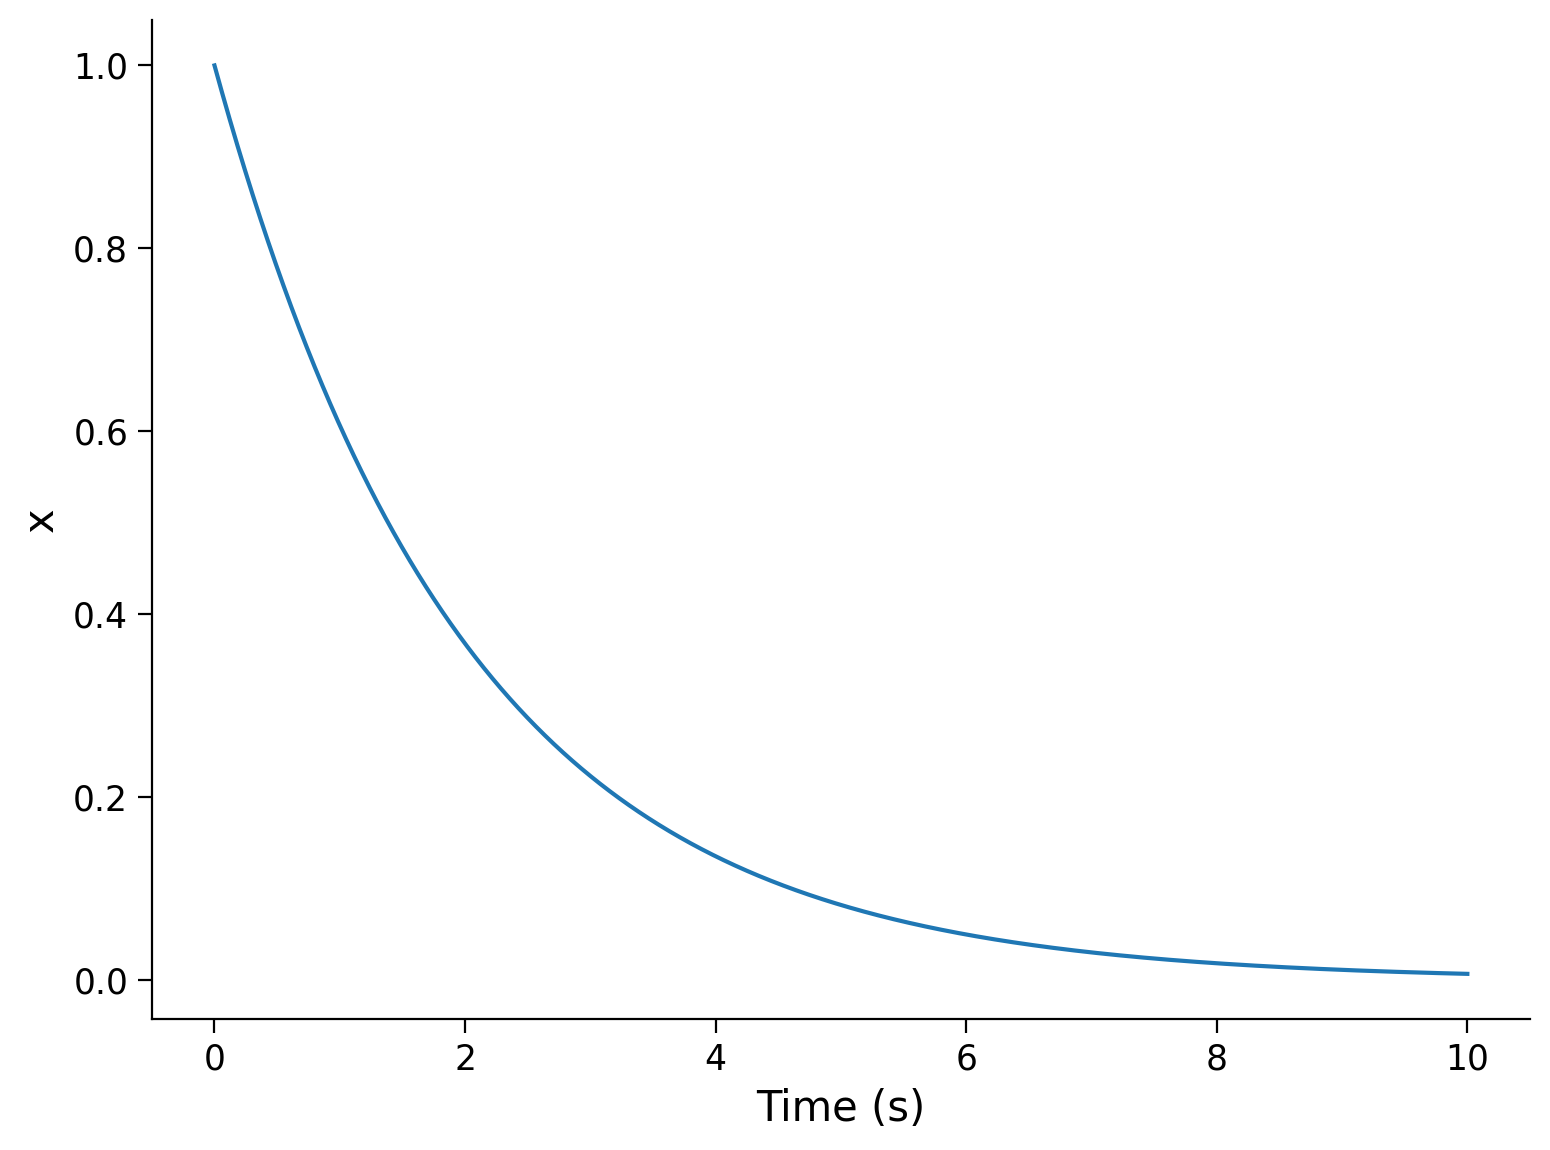

In [4]:
def integrate_exponential(a, x0, dt, T):
  """Compute solution of the differential equation xdot=a*x with
  initial condition x0 for a duration T. Use time step dt for numerical
  solution.

  Args:
    a (scalar): parameter of xdot (xdot=a*x)
    x0 (scalar): initial condition (x at time 0)
    dt (scalar): timestep of the simulation
    T (scalar): total duration of the simulation

  Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
  """

  # Initialize variables
  t = np.arange(0, T, dt)
  x = np.zeros_like(t, dtype=complex)
  x[0] = x0 # This is x at time t_0

  # Step through system and integrate in time
  for k in range(1, len(t)):

    # for each point in time, compute xdot from x[k-1]
    xdot = a * x[k-1]

    # Update x based on x[k-1] and xdot
    x[k] = x[k-1] + xdot * dt

  return x, t


# Choose parameters
a = -0.5    # parameter in f(x)
T = 10      # total Time duration
dt = 0.001  # timestep of our simulation
x0 = 1.     # initial condition of x at time 0

# Use Euler's method
x, t = integrate_exponential(a, x0, dt, T)

# Visualize
plt.plot(t, x.real)
plt.xlabel('Time (s)')
plt.ylabel('x')
plt.show()

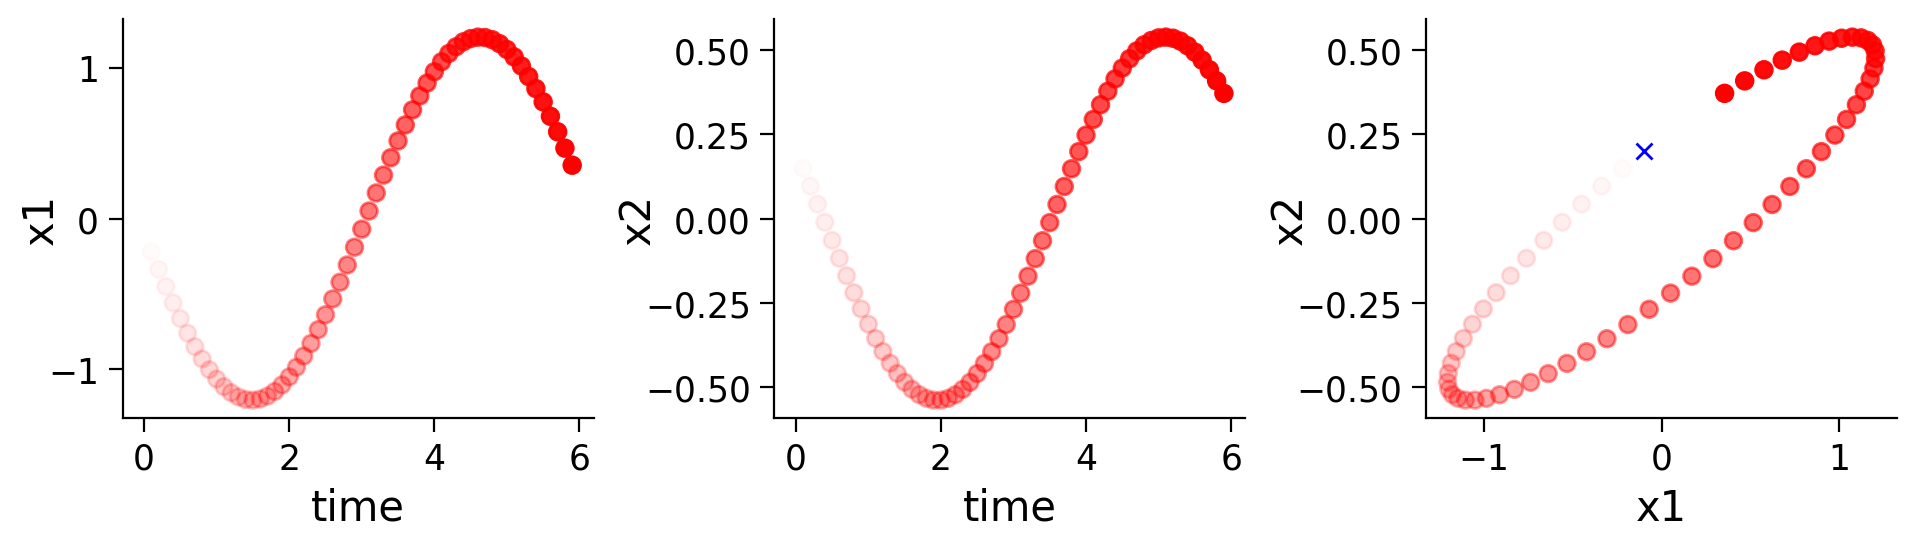

In [5]:
def system(t, x, a00, a01, a10, a11):
  '''
  Compute the derivative of the state x at time t for a linear
  differential equation with A matrix [[a00, a01], [a10, a11]].

  Args:
    t (float): time
    x (ndarray): state variable
    a00, a01, a10, a11 (float): parameters of the system

  Returns:
    ndarray: derivative xdot of state variable x at time t
  '''

  # compute x1dot and x2dot
  x1dot = a00 * x[0] + a01 * x[1]
  x2dot = a10 * x[0] + a11 * x[1]

  return np.array([x1dot, x2dot])


# Set parameters
T = 6 # total time duration
dt = 0.1 # timestep of our simulation
A = np.array([[2, -5],
              [1, -2]])
x0 = [-0.1, 0.2]

# Simulate and plot trajectories
plot_trajectory(system, [A[0, 0], A[0, 1], A[1, 0], A[1, 1]], x0, dt=dt, T=T)

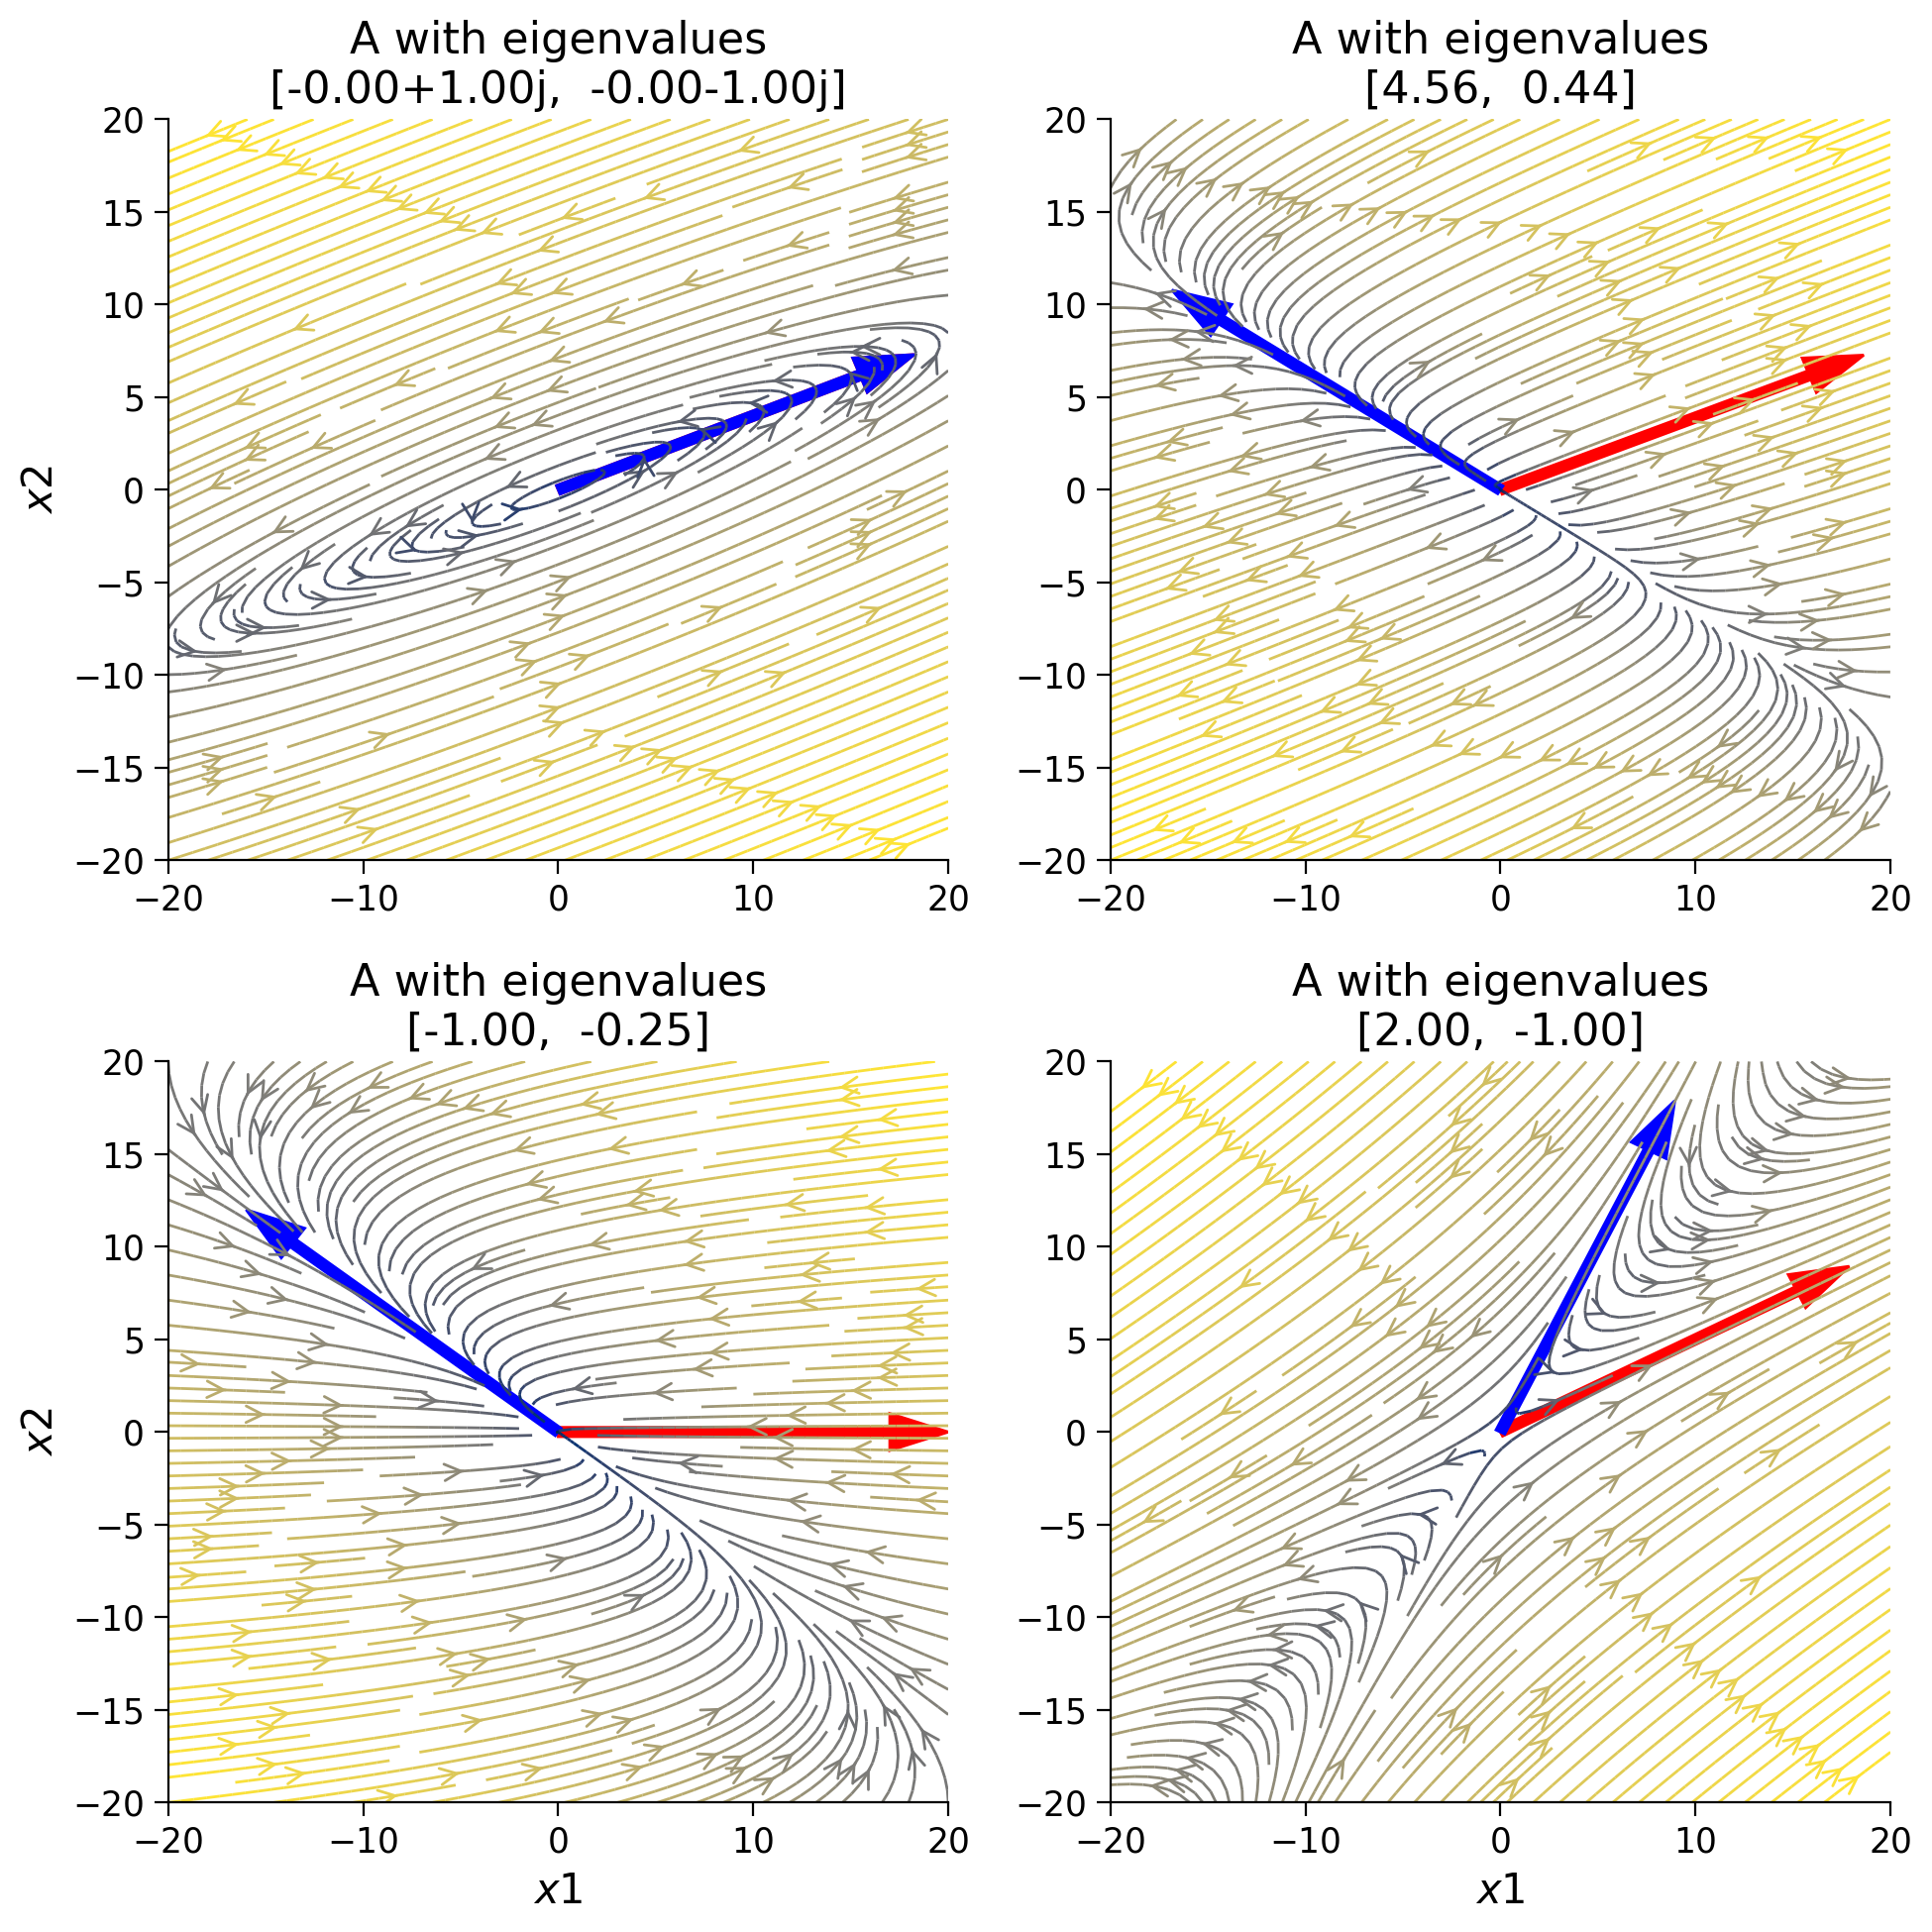

In [6]:
# @markdown Execute this cell to see stream plots

A_option_1 = np.array([[2, -5], [1, -2]])
A_option_2 = np.array([[3,4], [1, 2]])
A_option_3 = np.array([[-1, -1], [0, -0.25]])
A_option_4 = np.array([[3, -2], [2, -2]])

A_options = [A_option_1, A_option_2, A_option_3, A_option_4]
plot_specific_example_stream_plots(A_options)

# Markov Processes

#### Helper Functions

In [7]:
# @title Plotting Functions

def plot_switch_simulation(t, x):
  plt.figure()
  plt.plot(t, x)
  plt.title('State-switch simulation')
  plt.xlabel('Time')
  plt.xlim((0, 300)) # zoom in time
  plt.ylabel('State of ion channel 0/1', labelpad=-60)
  plt.yticks([0, 1], ['Closed (0)', 'Open (1)'])
  plt.show()


def plot_interswitch_interval_histogram(inter_switch_intervals):
  plt.figure()
  plt.hist(inter_switch_intervals)
  plt.title('Inter-switch Intervals Distribution')
  plt.ylabel('Interval Count')
  plt.xlabel('time')
  plt.show()


def plot_state_probabilities(time, states):
  plt.figure()
  plt.plot(time, states[:, 0], label='Closed')
  plt.plot(time, states[:, 1], label='Open')
  plt.xlabel('time')
  plt.ylabel('prob(open OR closed)')
  plt.legend()
  plt.show()

#### Markov

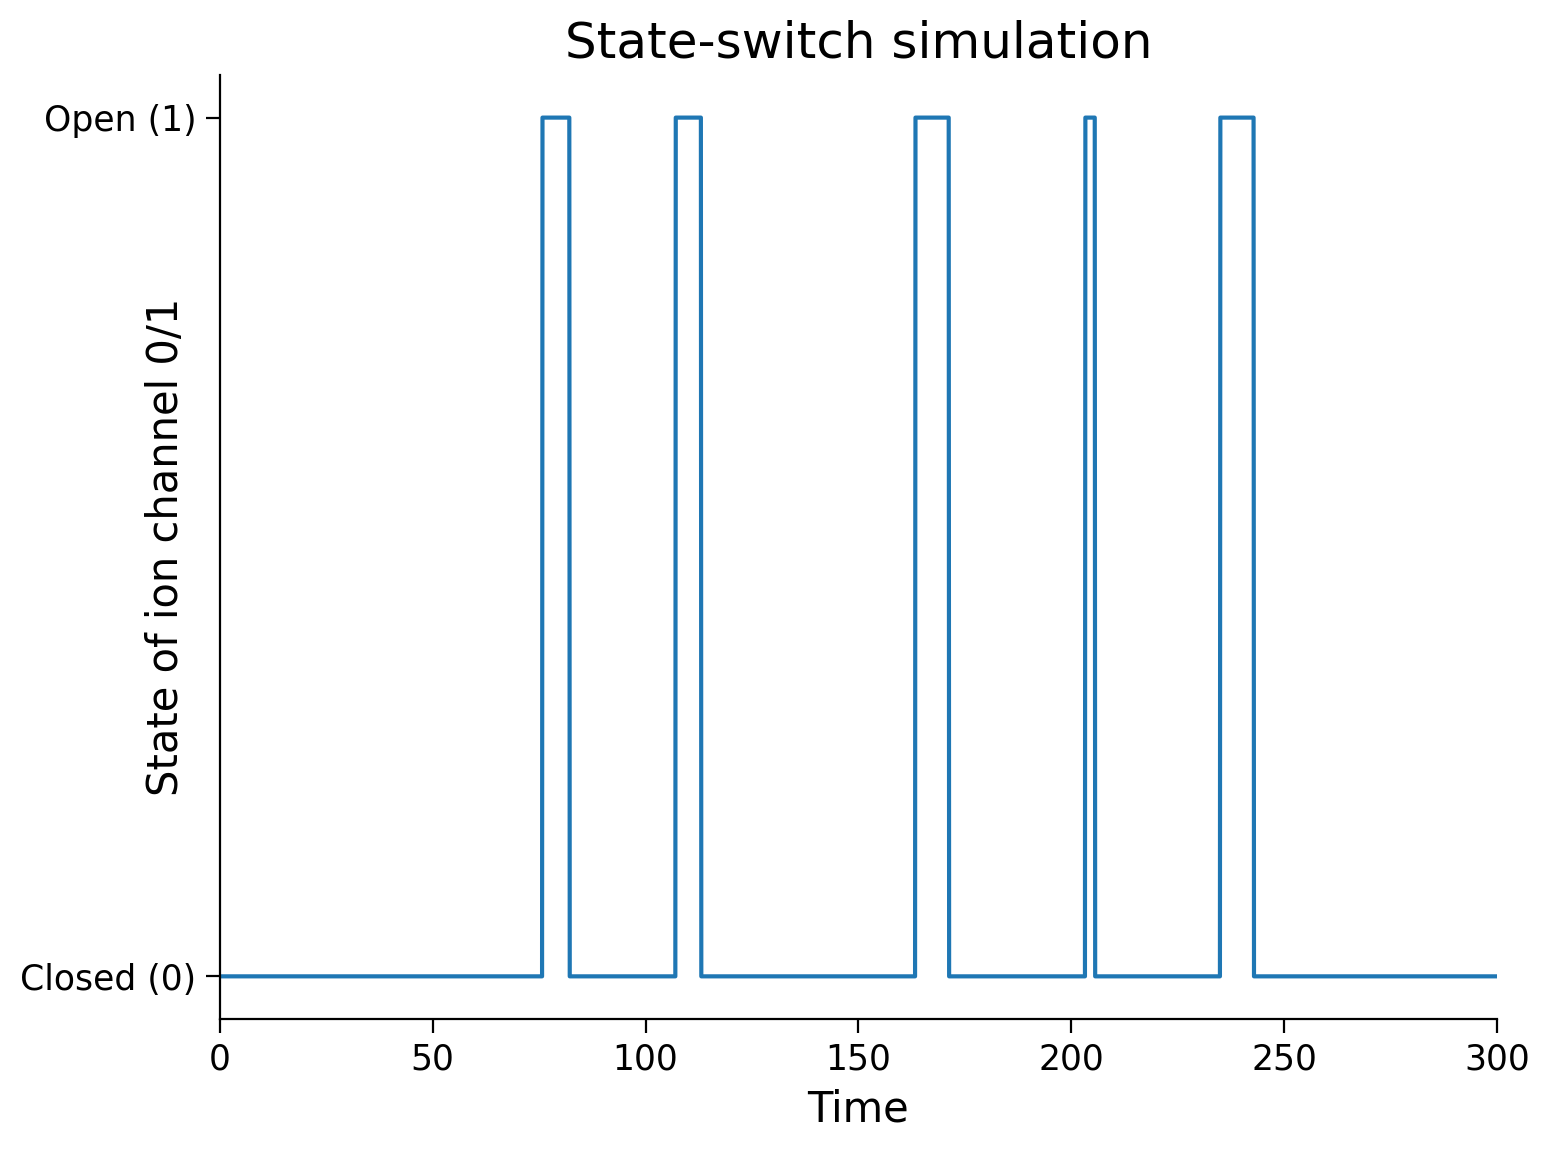

In [8]:
# parameters
T = 5000     # total Time duration
dt = 0.001   # timestep of our simulation

# simulate state of our ion channel in time
# the two parameters that govern transitions are
# c2o: closed to open rate
# o2c: open to closed rate
def ion_channel_opening(c2o, o2c, T, dt):
  # initialize variables
  t = np.arange(0, T, dt)
  x = np.zeros_like(t)
  switch_times = []

  # assume we always start in Closed state
  x[0] = 0

  # generate a bunch of random uniformly distributed numbers
  # between zero and unity: [0, 1),
  # one for each dt in our simulation.
  # we will use these random numbers to model the
  # closed/open transitions
  myrand = np.random.random_sample(size=len(t))


  # walk through time steps of the simulation
  for k in range(len(t)-1):
    # switching between closed/open states are
    # Poisson processes
    if x[k] == 0 and myrand[k] < c2o*dt: # remember to scale by dt!
      x[k+1:] = 1
      switch_times.append(k*dt)
    elif x[k] == 1 and myrand[k] < o2c*dt:
      x[k+1:] = 0
      switch_times.append(k*dt)

  return t, x, switch_times


c2o = 0.02
o2c = 0.1
np.random.seed(0) # set random seed
t, x, switch_times = ion_channel_opening(c2o, o2c, T, .1)
plot_switch_simulation(t, x)

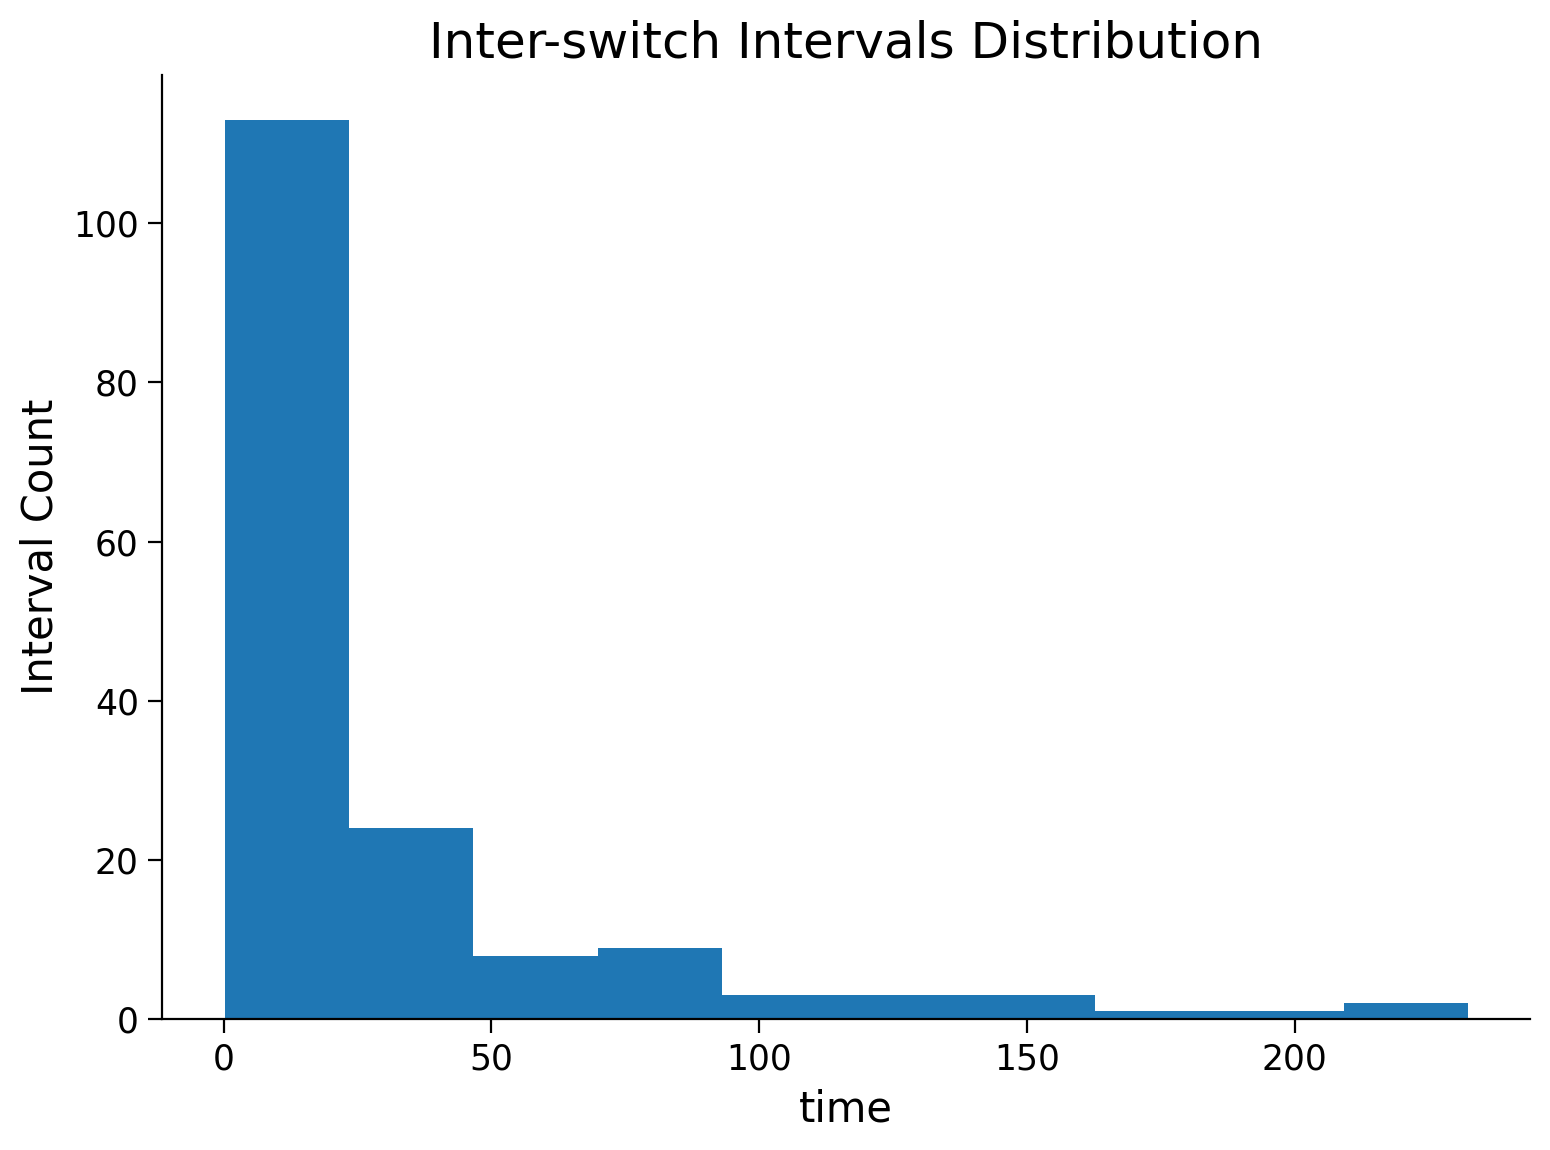

In [9]:

inter_switch_intervals = np.diff(switch_times)

# plot inter-switch intervals
plot_interswitch_interval_histogram(inter_switch_intervals)

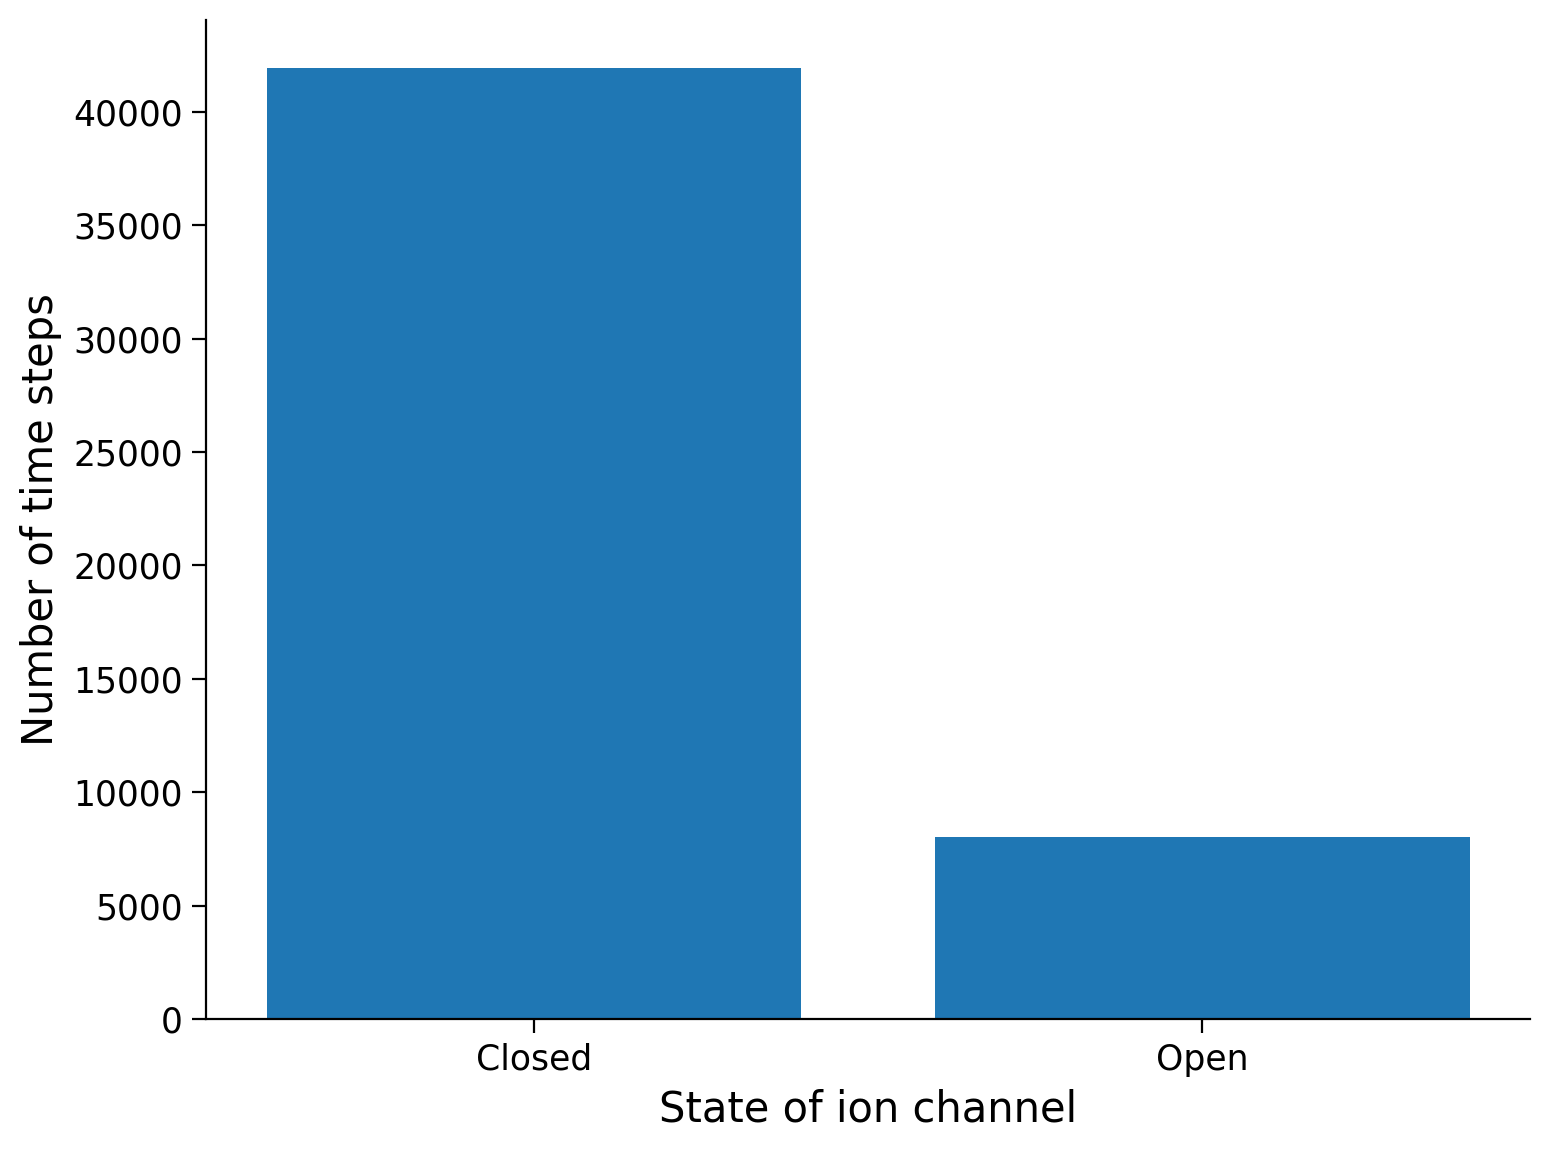

In [10]:
# @markdown Execute cell to visualize distribution of time spent in each state.

states = ['Closed', 'Open']
(unique, counts) = np.unique(x, return_counts=True)

plt.figure()
plt.bar(states, counts)
plt.ylabel('Number of time steps')
plt.xlabel('State of ion channel')
plt.show()

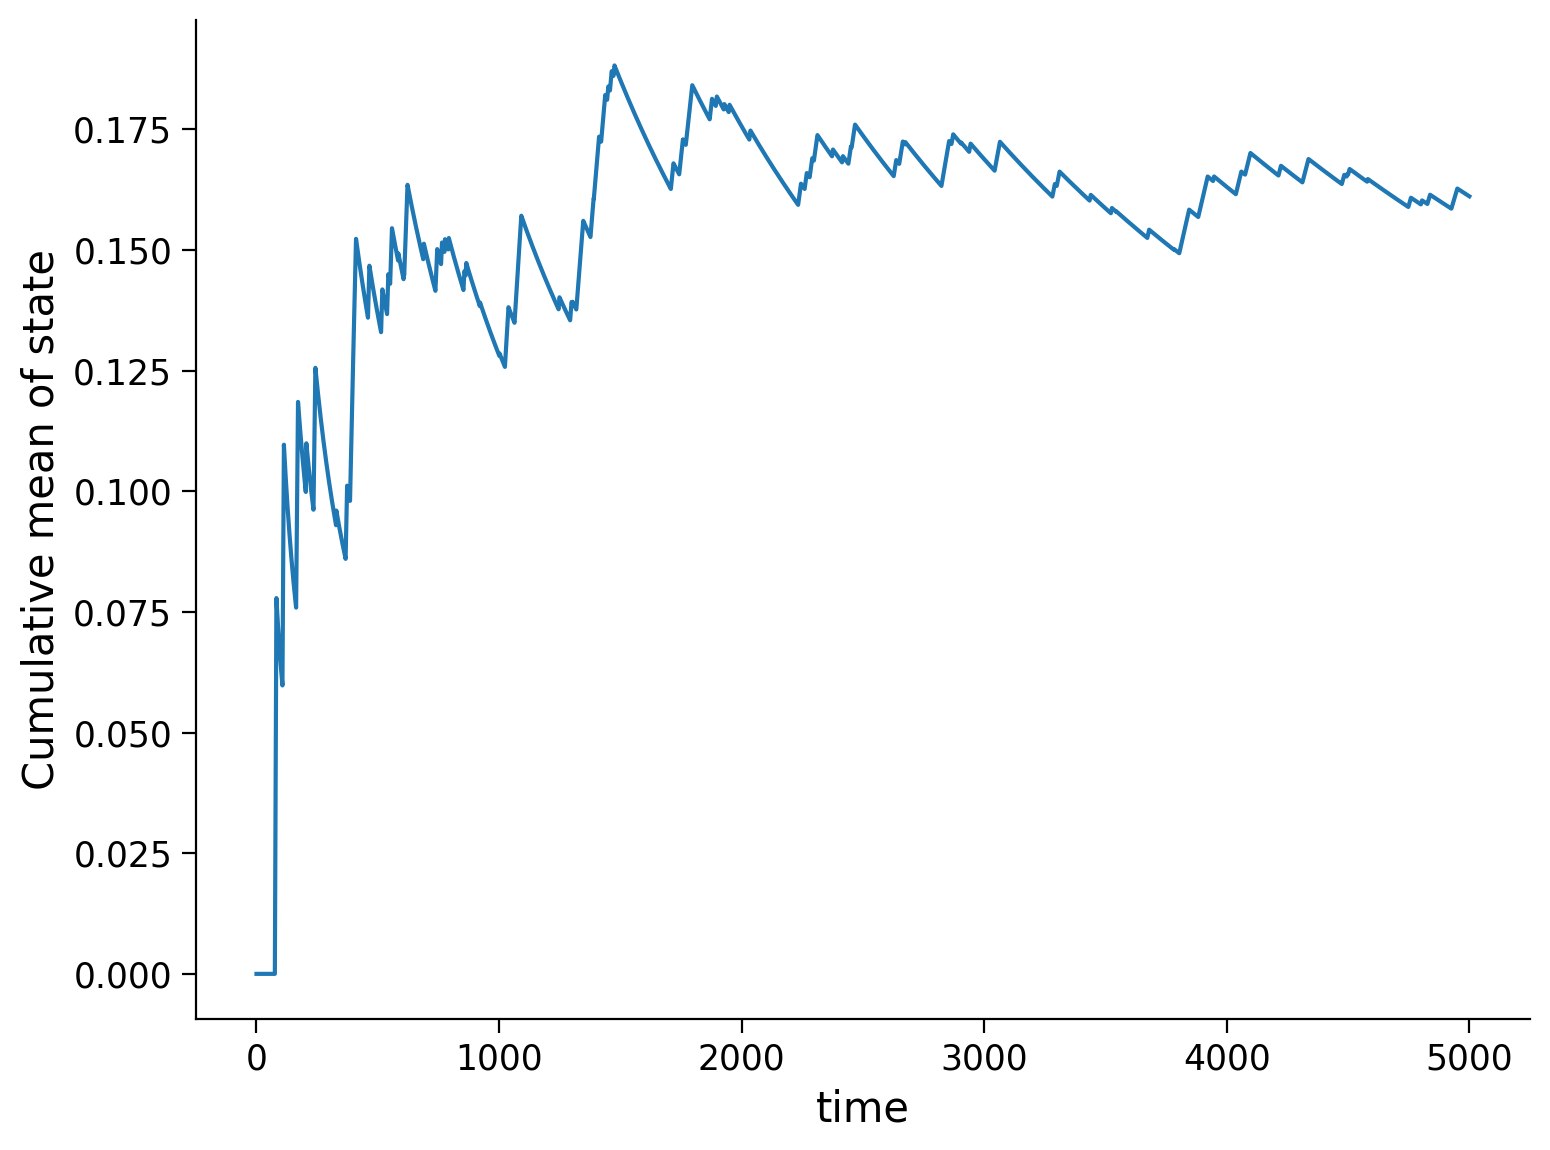

In [11]:
# @markdown Execute to visualize cumulative mean of state
plt.figure()
plt.plot(t, np.cumsum(x) / np.arange(1, len(t)+1))
plt.xlabel('time')
plt.ylabel('Cumulative mean of state')
plt.show()

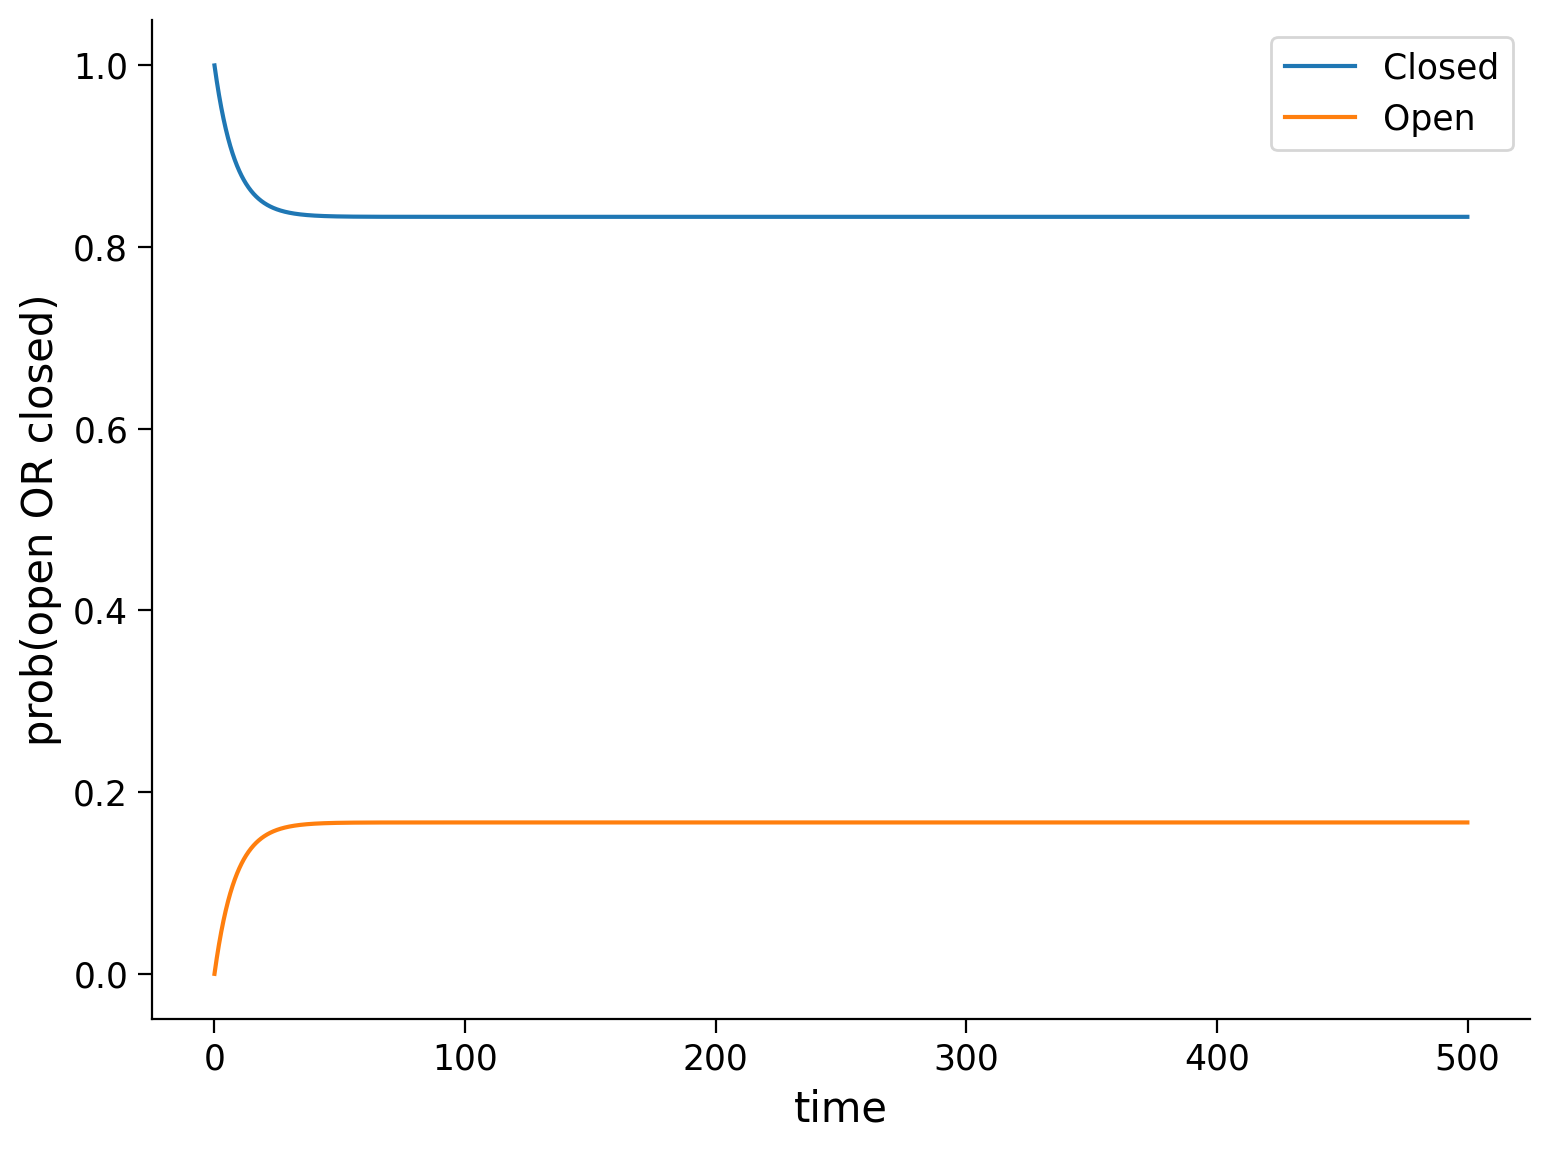

In [16]:
def simulate_prob_prop(A, x0, dt, T):
  """ Simulate the propagation of probabilities given the transition matrix A,
  with initial state x0, for a duration of T at timestep dt.

  Args:
    A (ndarray): state transition matrix
    x0 (ndarray): state probabilities at time 0
    dt (scalar): timestep of the simulation
    T (scalar): total duration of the simulation

  Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
  """

  # Initialize variables
  t = np.arange(0, T, dt)
  x = x0 # x at time t_0

  # Step through the system in time
  for k in range(len(t)-1):

    # Compute the state of x at time k+1
    x_kp1 = np.dot(A, x[-1, :])

    # Stack (append) this new state onto x to keep track of x through time steps
    x = np.vstack((x, x_kp1))

  return x, t


# Set parameters
T = 500     # total Time duration
dt = 0.1   # timestep of our simulation

# same parameters as above
# c: closed rate
# o: open rate
c = 0.02
o = 0.1
A = np.array([[1 - c*dt, o*dt],
              [c*dt,     1 - o*dt]])

# Initial condition: start as Closed
x0 = np.array([[1, 0]])

# Simulate probabilities propagation
x, t = simulate_prob_prop(A, x0, dt, T)

# Visualize
plot_state_probabilities(t, x)

In [17]:
print(f"Probability of state c2o: {(c2o / (c2o + o2c)):.3f}")

Probability of state c2o: 0.167


In [18]:
# compute the eigendecomposition of A
lam, v = np.linalg.eig(A)

# print the 2 eigenvalues
print(f"Eigenvalues: {lam}")

# print the 2 eigenvectors
eigenvector1 = v[:, 0]
eigenvector2 = v[:, 1]
print(f"Eigenvector 1: {eigenvector1}")
print(f"Eigenvector 2: {eigenvector2}")

Eigenvalues: [1.    0.988]
Eigenvector 1: [0.98058068 0.19611614]
Eigenvector 2: [-0.70710678  0.70710678]


# Determinism and Stochasticity

#### Helper Functions

In [20]:
def plot_random_walk_sims(sims, nsims=10):
  """Helper for exercise 3A"""
  plt.figure()
  plt.plot(sims[:nsims, :].T)
  plt.xlabel('time')
  plt.ylabel('position x')
  plt.show()


def plot_mean_var_by_timestep(mu, var):
  """Helper function for exercise 3A.2"""
  fig, (ah1, ah2) = plt.subplots(2)

  # plot mean of distribution as a function of time
  ah1.plot(mu)
  ah1.set(ylabel='mean')
  ah1.set_ylim([-5, 5])

  # plot variance of distribution as a function of time
  ah2.plot(var)
  ah2.set(xlabel='time')
  ah2.set(ylabel='variance')

  plt.show()


def plot_ddm(t, x, xinfty, lam, x0):
  plt.figure()
  plt.plot(t, xinfty * (1 - lam**t) + x0 * lam**t, 'r',
           label='deterministic solution')
  plt.plot(t, x, 'k.', label='simulation')  # simulated data pts
  plt.xlabel('t')
  plt.ylabel('x')
  plt.legend()
  plt.show()


def var_comparison_plot(empirical, analytical):
  plt.figure()
  plt.plot(empirical, analytical, '.', markersize=15)
  plt.xlabel('empirical equilibrium variance')
  plt.ylabel('analytic equilibrium variance')
  plt.plot(np.arange(8), np.arange(8), 'k', label='45 deg line')
  plt.legend()
  plt.grid(True)
  plt.show()


def plot_dynamics(x, t, lam, xinfty=0):
  """ Plot the dynamics """
  plt.figure()
  plt.title('$\\lambda=%0.1f$' % lam, fontsize=16)
  x0 = x[0]
  plt.plot(t, xinfty + (x0 - xinfty) * lam**t, 'r', label='analytic solution')
  plt.plot(t, x, 'k.', label='simulation')  # simulated data pts
  plt.ylim(0, x0+1)
  plt.xlabel('t')
  plt.ylabel('x')
  plt.legend()
  plt.show()

#### Random Walks

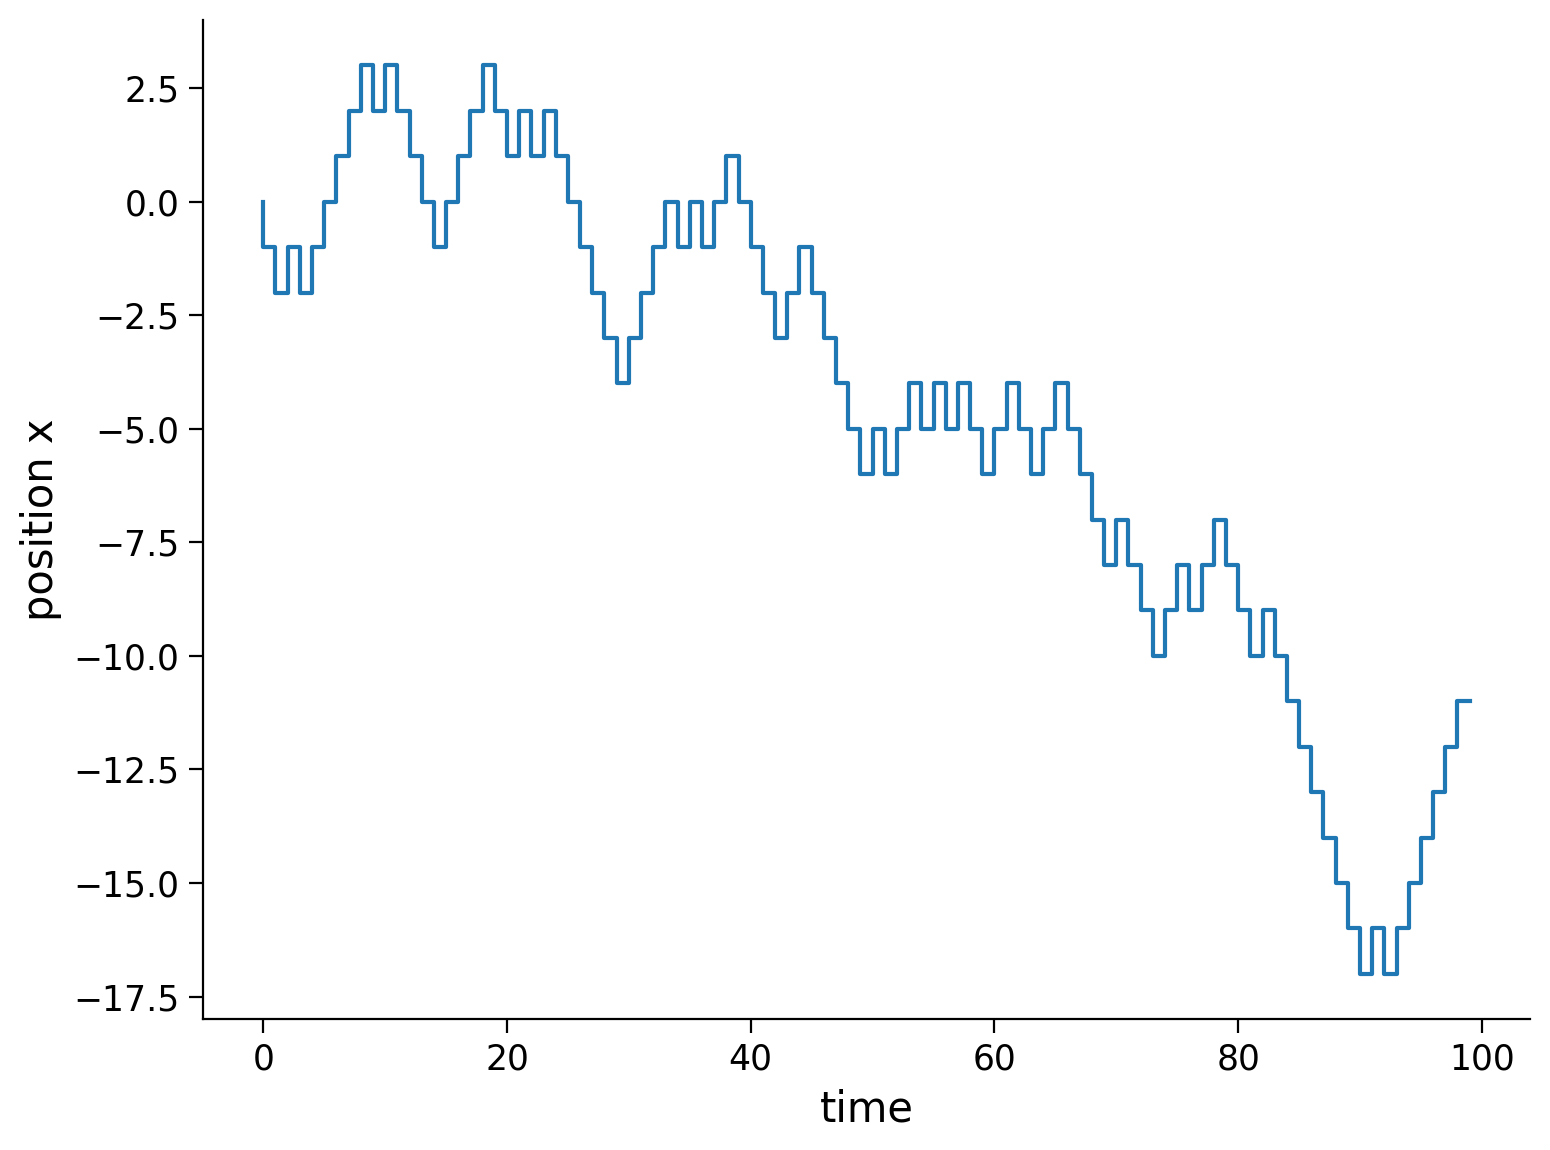

In [21]:
# @markdown Execute to simulate and visualize a random walk
# parameters of simulation
T = 100
t = np.arange(T)
x = np.zeros_like(t)
np.random.seed(2020) # set random seed

# initial position
x[0] = 0

# step forward in time
for k in range(len(t)-1):
    # choose randomly between -1 and 1 (coin flip)
    this_step = np.random.choice([-1,1])

    # make the step
    x[k+1] = x[k] + this_step

# plot this trajectory
plt.figure()
plt.step(t, x)
plt.xlabel('time')
plt.ylabel('position x')
plt.show()

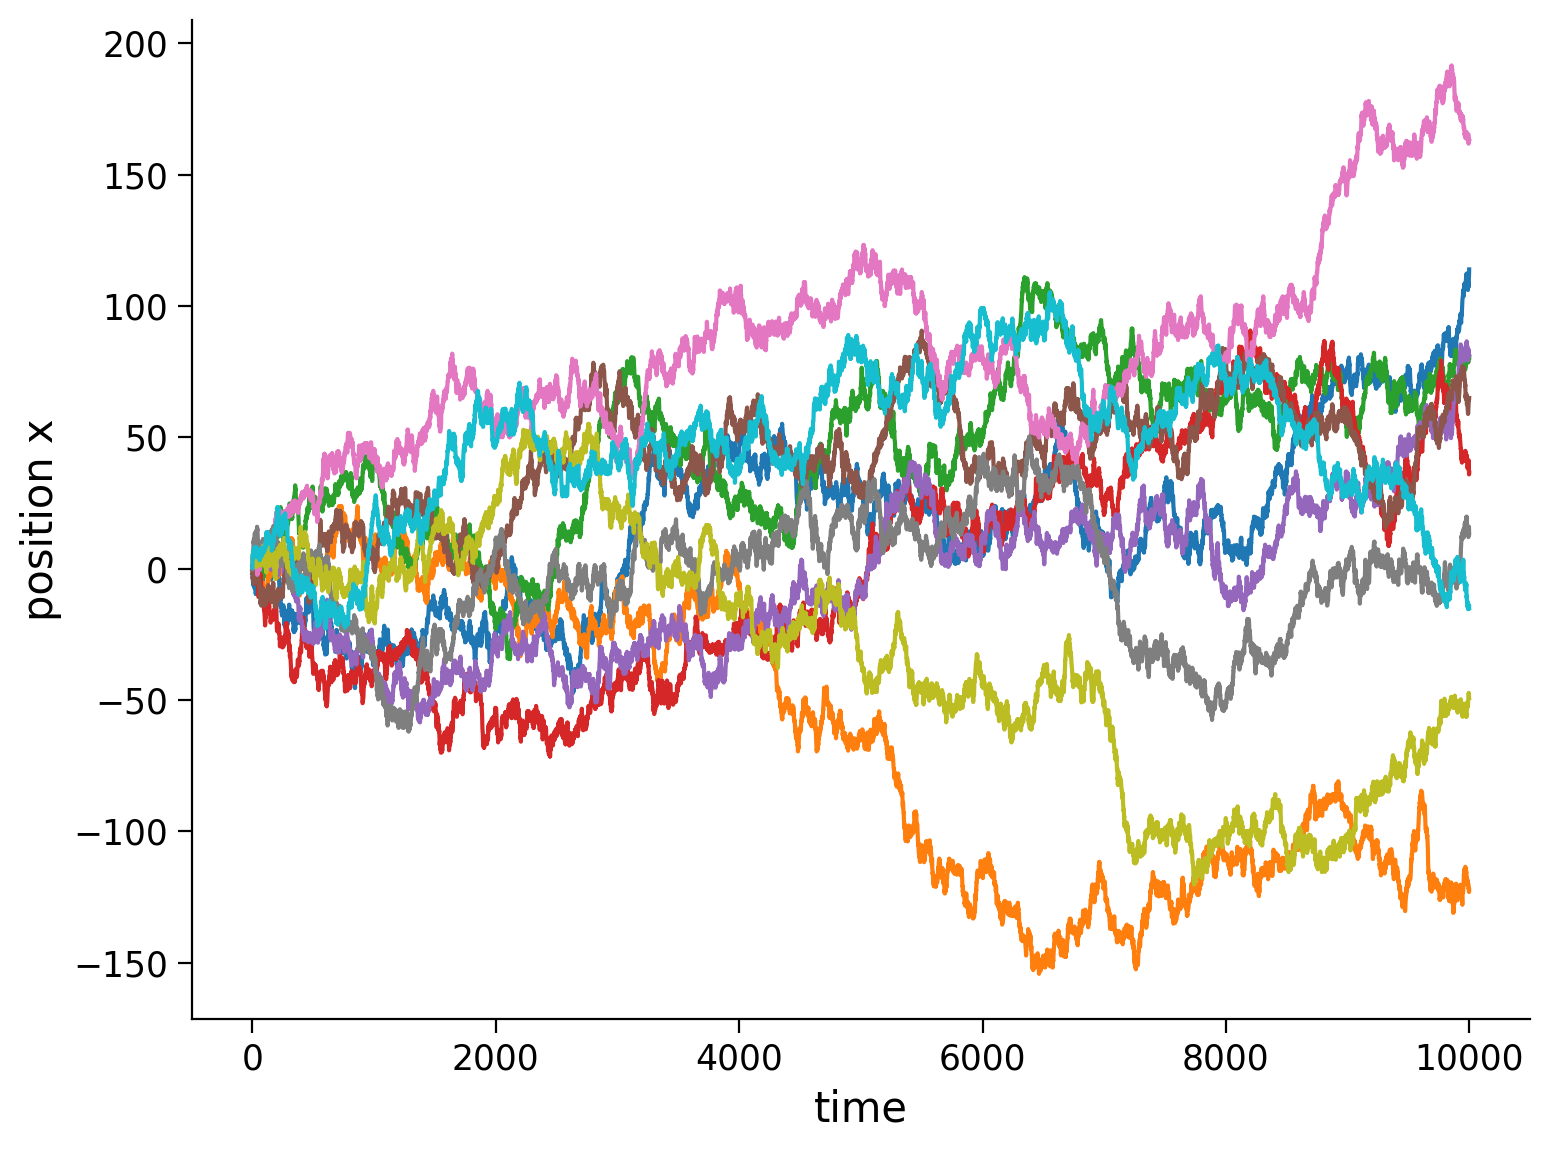

In [22]:
def random_walk_simulator(N, T, mu=0, sigma=1):
  '''Simulate N random walks for T time points. At each time point, the step
      is drawn from a Gaussian distribution with mean mu and standard deviation
      sigma.

  Args:
    T (integer) : Duration of simulation in time steps
    N (integer) : Number of random walks
    mu (float) : mean of step distribution
    sigma (float) : standard deviation of step distribution

  Returns:
    (numpy array) : NxT array in which each row corresponds to trajectory
  '''

  
  # generate all the random steps for all steps in all simulations in one go
  # produces a N x T array
  steps = np.random.normal(mu, sigma, size=(N, T))

  # compute the cumulative sum of all the steps over the time axis
  sim = np.cumsum(steps, axis=1)

  return sim


np.random.seed(2020) # set random seed

# simulate 1000 random walks for 10000 time steps
sim = random_walk_simulator(1000, 10000,  mu=0, sigma=1)

# take a peek at the first 10 simulations
plot_random_walk_sims(sim, nsims=10)

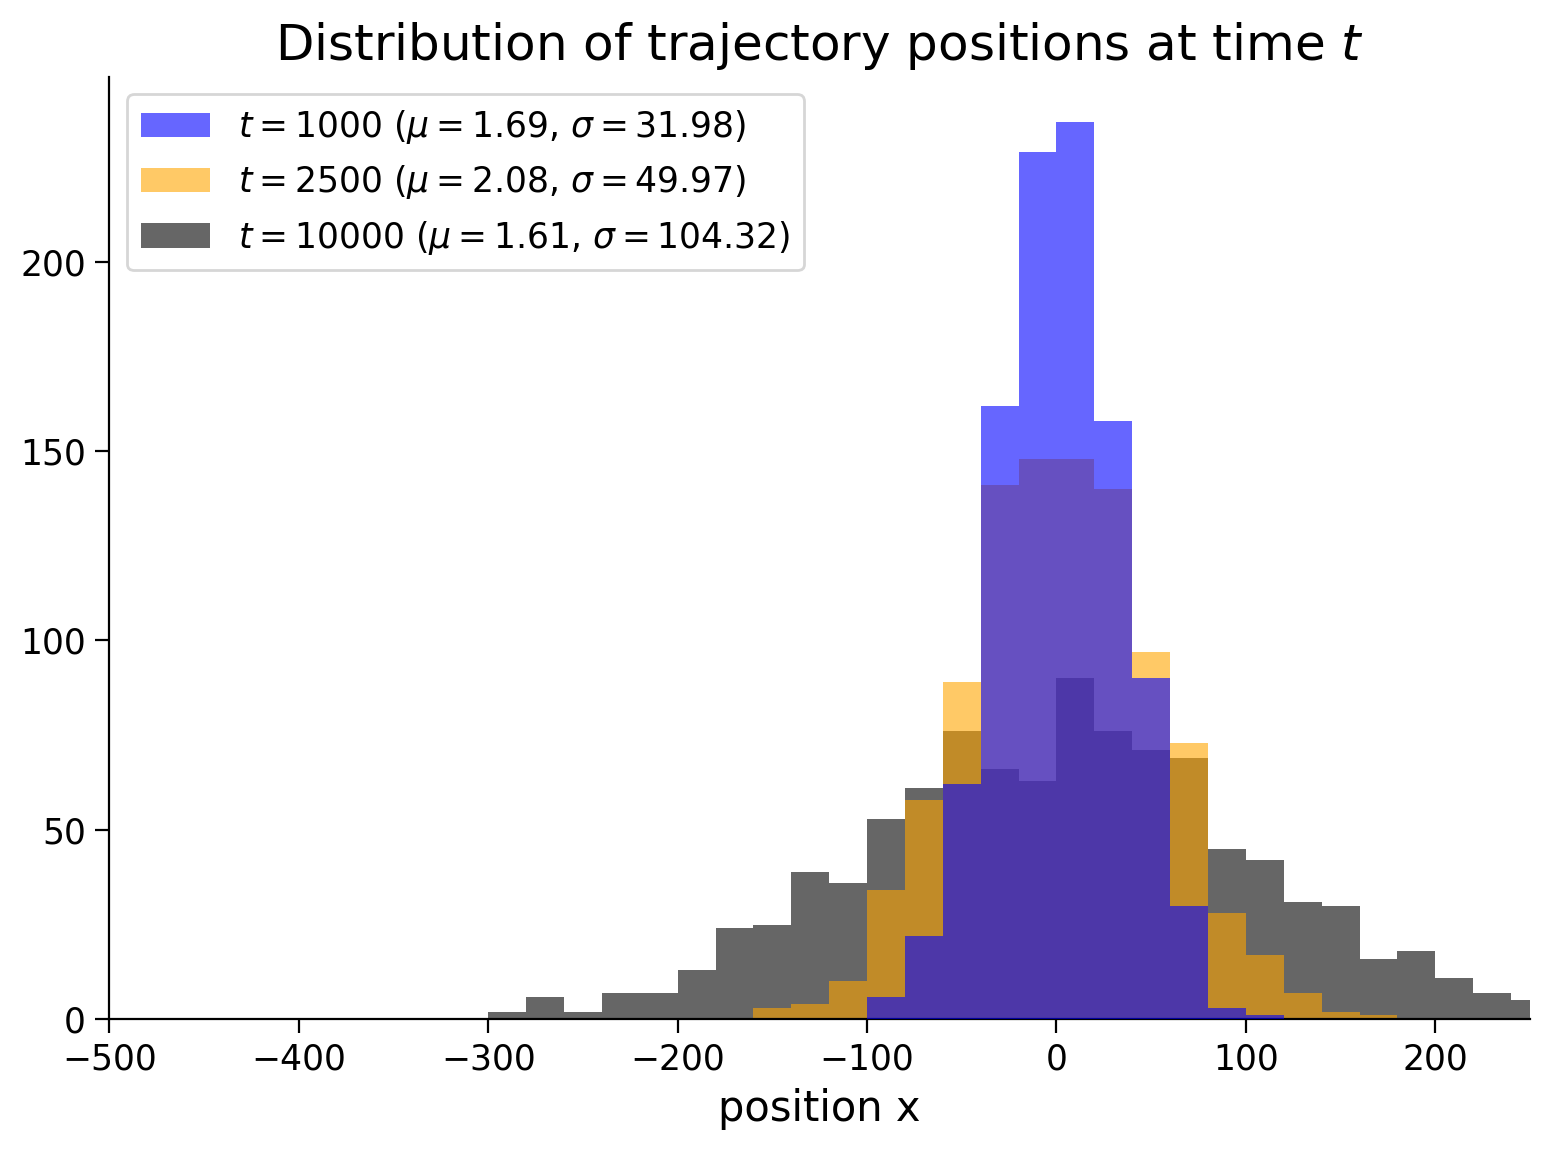

In [24]:
# @markdown Execute to visualize distribution of bacteria positions
fig = plt.figure()
# look at the distribution of positions at different times
for i, t in enumerate([1000, 2500, 10000]):

  # get mean and standard deviation of distribution at time t
  mu = sim[:, t-1].mean()
  sig2 = sim[:, t-1].std()

  # make a plot label
  mytitle = '$t=${time:d} ($\\mu=${mu:.2f}, $\\sigma=${var:.2f})'

  # plot histogram
  plt.hist(sim[:,t-1],
           color=['blue','orange','black'][i],
           # make sure the histograms have the same bins!
           bins=np.arange(-300, 300, 20),
           # make histograms a little see-through
           alpha=0.6,
           # draw second histogram behind the first one
           zorder=3-i,
           label=mytitle.format(time=t, mu=mu, var=sig2))

  plt.xlabel('position x')

  # plot range
  plt.xlim([-500, 250])

  # add legend
  plt.legend(loc=2)

# add title
plt.title(r'Distribution of trajectory positions at time $t$')
plt.show()

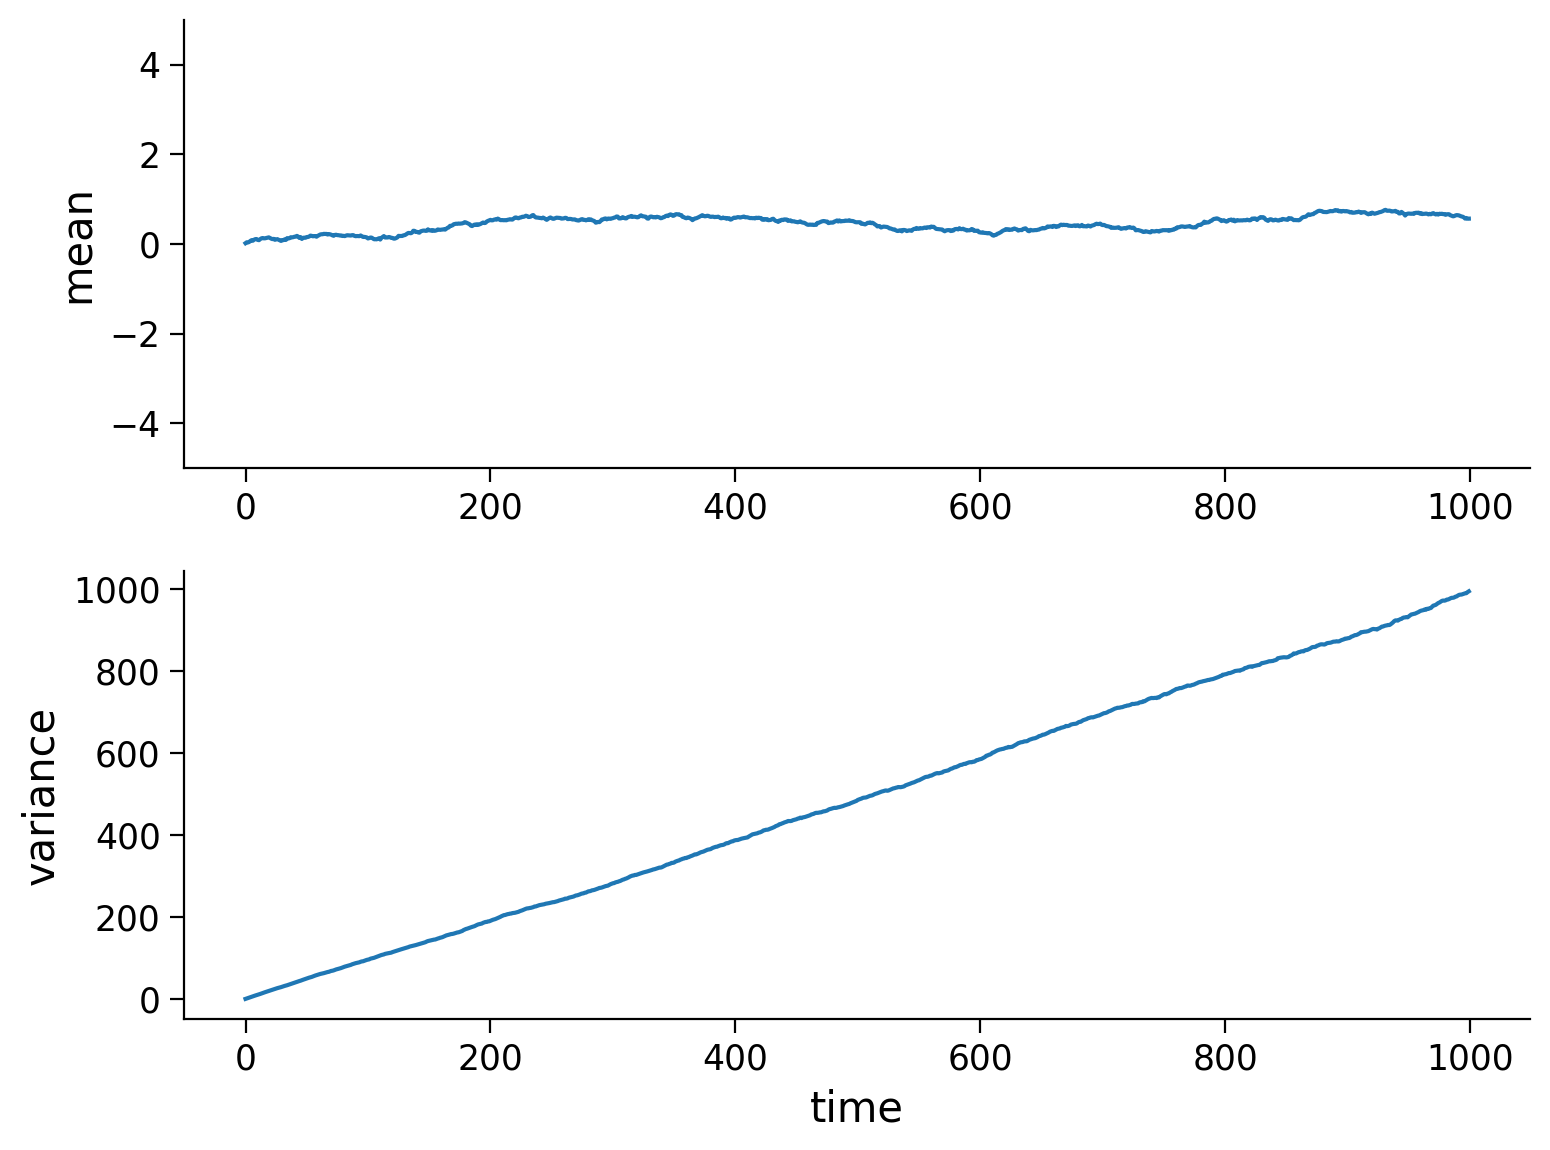

In [25]:
# Simulate random walks
np.random.seed(2020) # set random seed
sim = random_walk_simulator(5000, 1000, mu=0, sigma=1)

# Compute mean
mu = np.mean(sim, axis=0)

# Compute variance
var = np.var(sim, axis=0)

# Visualize
plot_mean_var_by_timestep(mu, var)

In [ ]:
@widgets.interact
def plot_gaussian(mean=(-0.5, 0.5, .02), std=(.5, 10, .5)):
  sim = random_walk_simulator(5000, 1000, mu=mean, sigma=std)
  # compute the mean and variance of trajectory positions at every time point
  mu = np.mean(sim, axis=0)
  var = np.var(sim, axis=0)
  # make a figure
  fig, (ah1, ah2) = plt.subplots(2)
  # plot mean of distribution as a function of time
  ah1.plot(mu)
  ah1.set(ylabel='mean')
  # plot variance of distribution as a function of time
  ah2.plot(var)
  ah2.set(xlabel='time')
  ah2.set(ylabel='variance')
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='mean', max=0.5, min=-0.5, step=0.02), FloatSlider(va…

#### The Ornstein-Uhlenbeck (OU) process

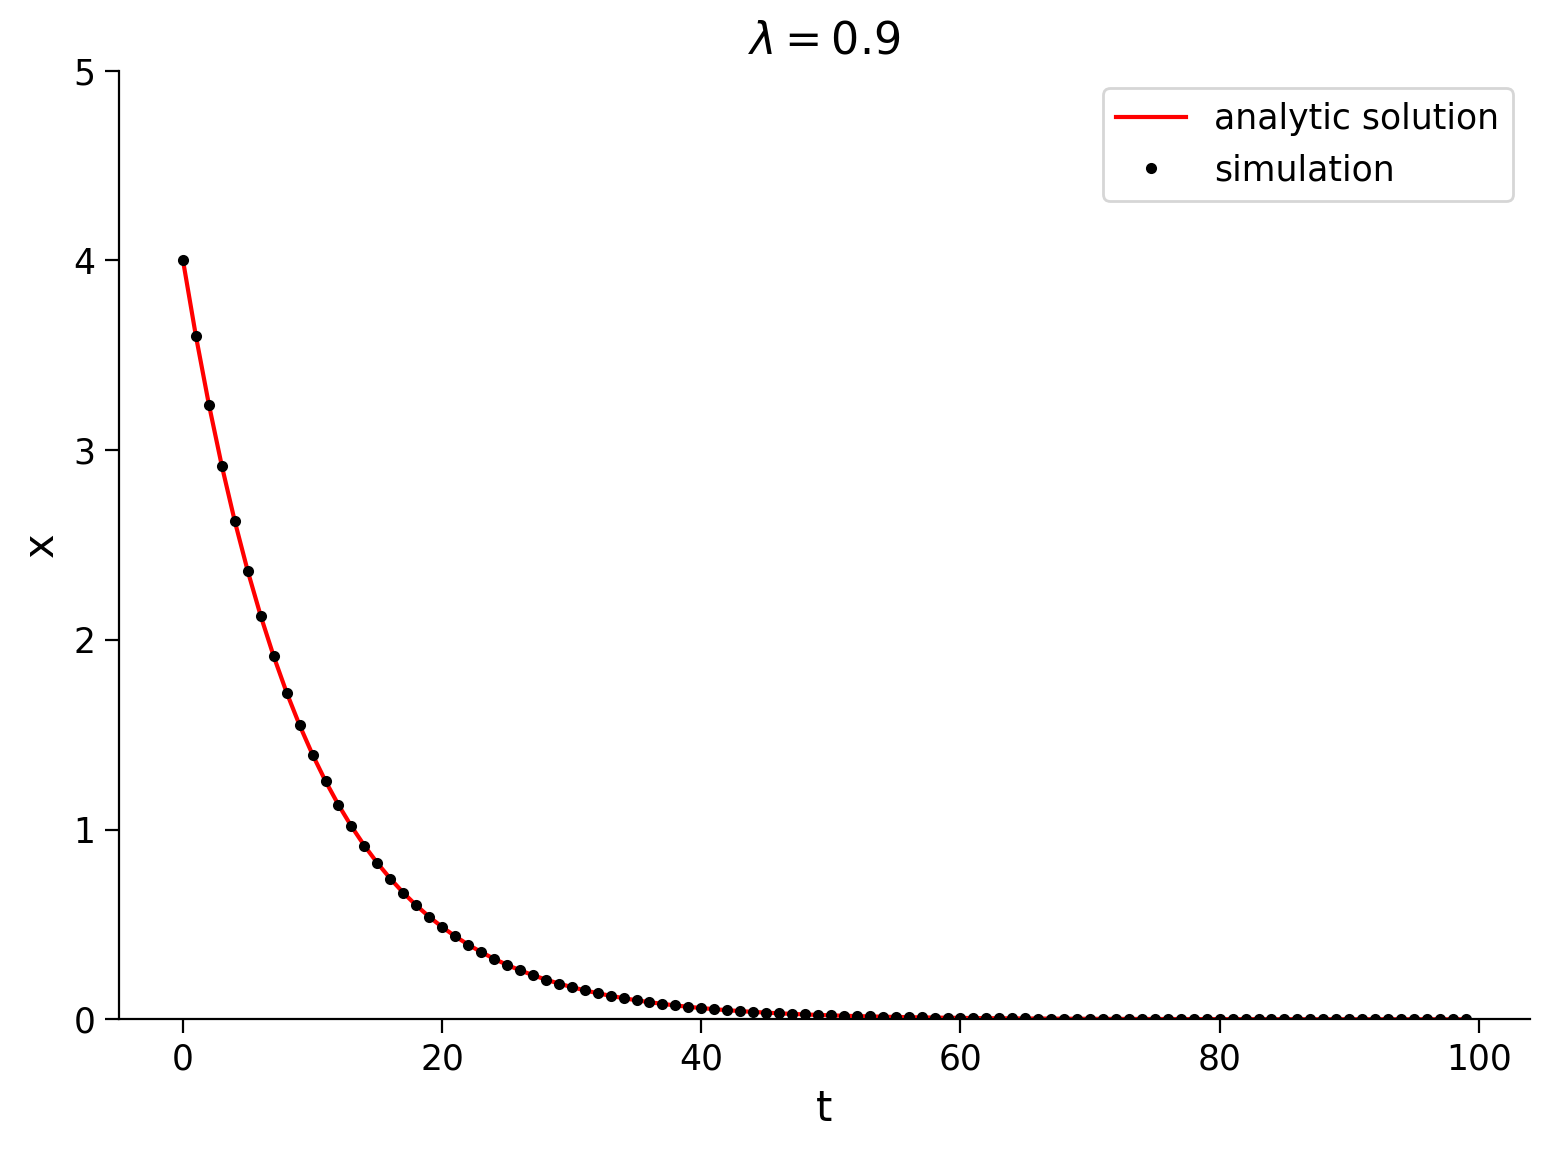

In [27]:
# parameters
lam = 0.9
T = 100  # total Time duration in steps
x0 = 4.  # initial condition of x at time 0

# initialize variables
t = np.arange(0, T, 1.)
x = np.zeros_like(t)
x[0] = x0

# Step through in time
for k in range(len(t)-1):
  x[k+1] = lam * x[k]

# plot x as it evolves in time
plot_dynamics(x, t, lam)

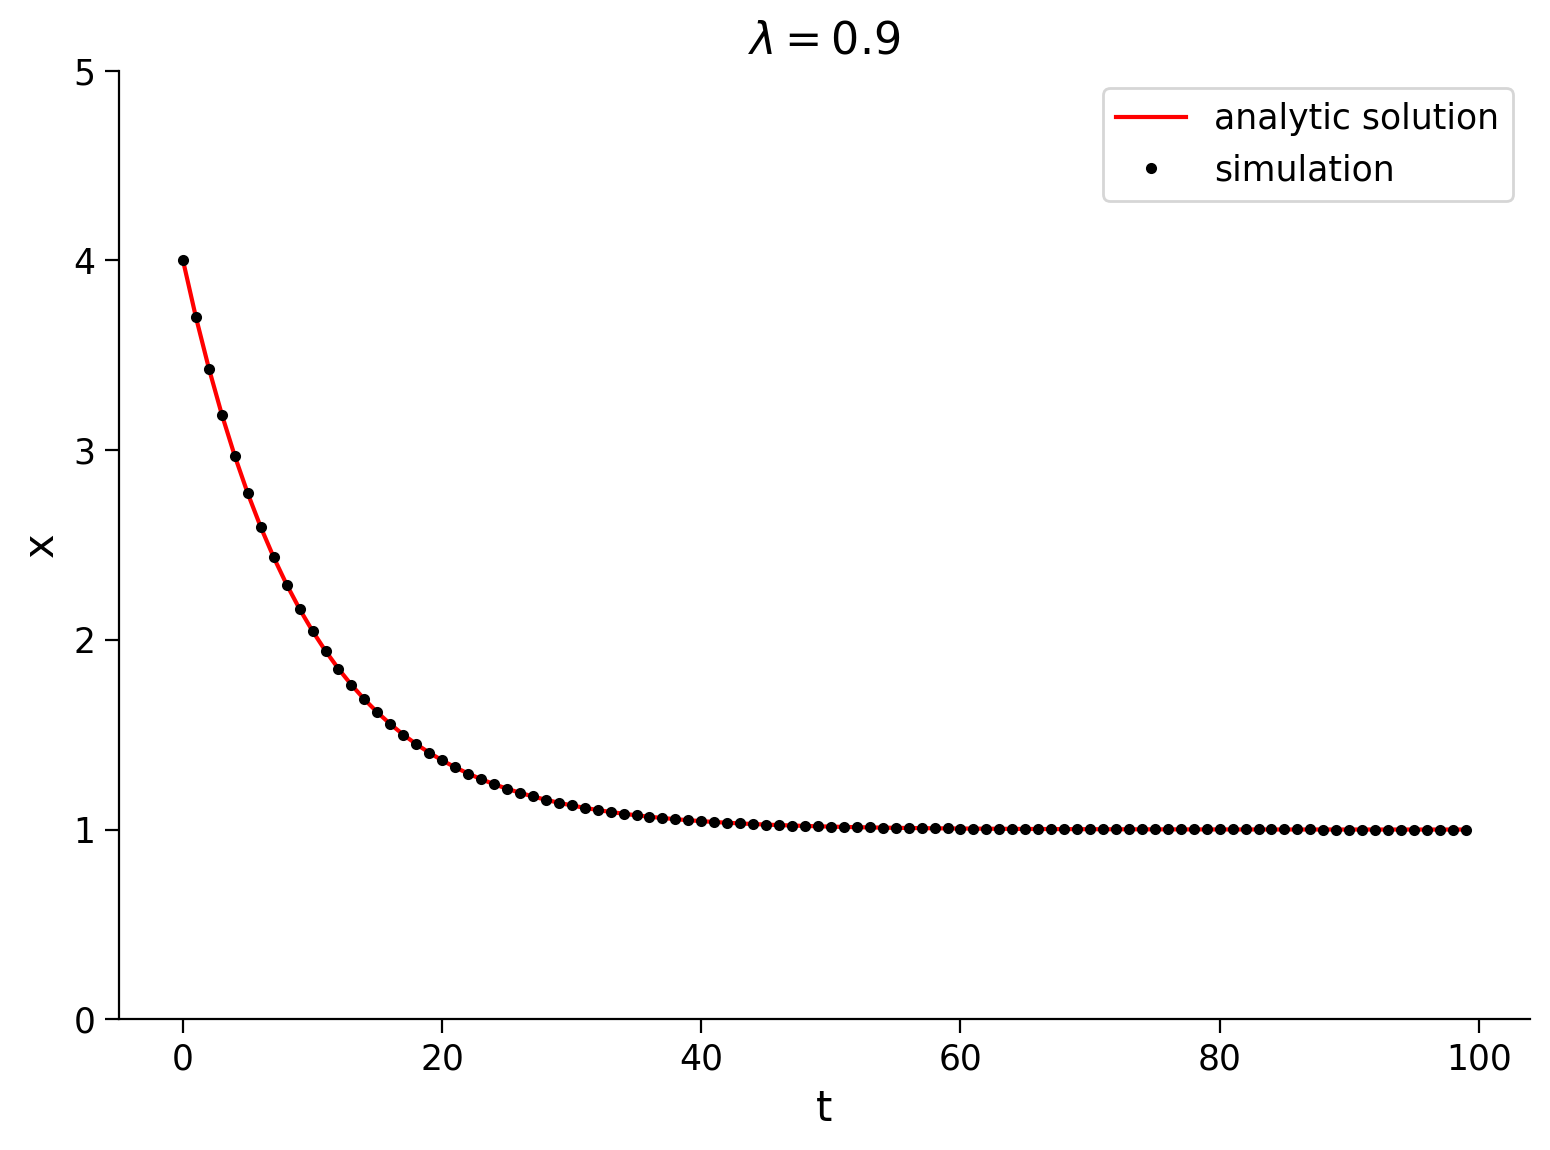

In [28]:
# parameters
lam = 0.9  # decay rate
T = 100  # total Time duration in steps
x0 = 4.  # initial condition of x at time 0
xinfty = 1.  # x drifts towards this value in long time

# initialize variables
t = np.arange(0, T, 1.)
x = np.zeros_like(t)
x[0] = x0

# Step through in time
for k in range(len(t)-1):
  x[k+1] = xinfty + lam * (x[k] - xinfty)

# plot x as it evolves in time
plot_dynamics(x, t, lam, xinfty)

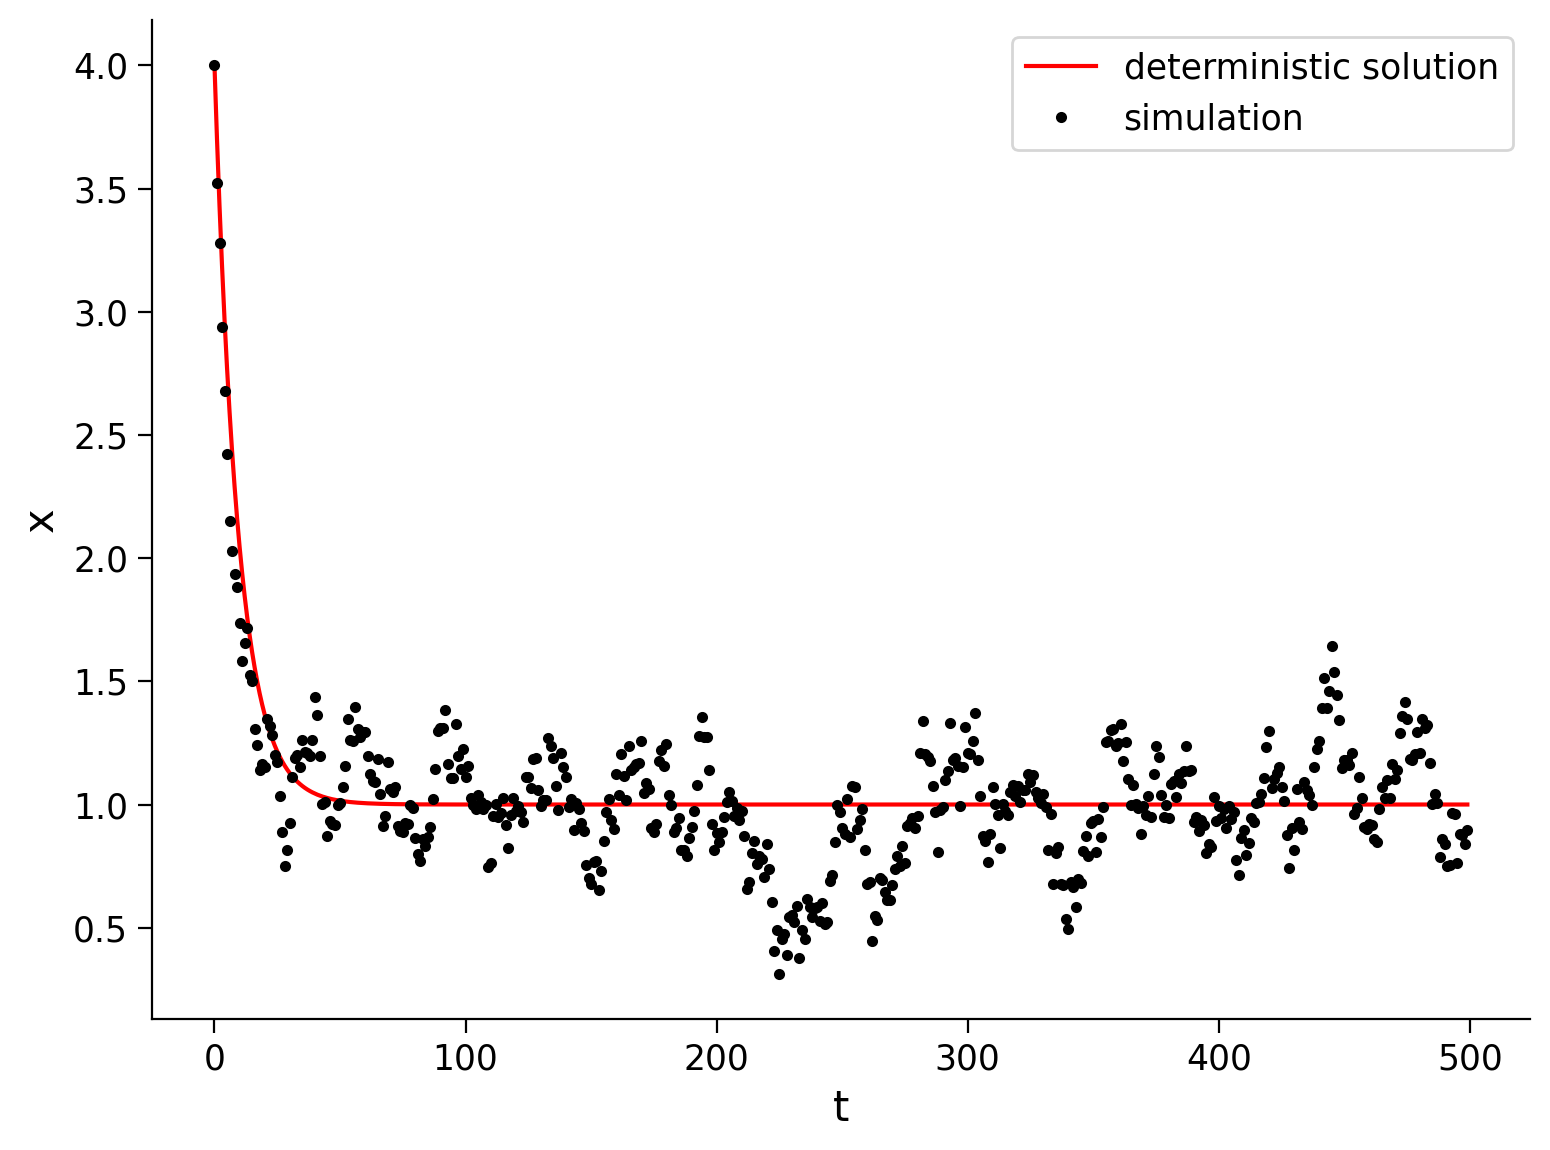

In [29]:
def simulate_ddm(lam, sig, x0, xinfty, T):
  """
  Simulate the drift-diffusion model with given parameters and initial condition.
  Args:
    lam (scalar): decay rate
    sig (scalar): standard deviation of normal distribution
    x0 (scalar): initial condition (x at time 0)
    xinfty (scalar): drift towards convergence in the limit
    T (scalar): total duration of the simulation (in steps)

  Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
  """

  # initialize variables
  t = np.arange(0, T, 1.)
  x = np.zeros_like(t)
  x[0] = x0

  # Step through in time
  for k in range(len(t)-1):
    
    # update x at time k+1 with a deterministic and a stochastic component
    # hint: the deterministic component will be like above, and
    #   the stochastic component is drawn from a scaled normal distribution
    x[k+1] = xinfty + lam * (x[k] - xinfty) + np.random.normal(0, sig)

  return t, x


lam = 0.9  # decay rate
sig = 0.1  # standard deviation of diffusive process
T = 500  # total Time duration in steps
x0 = 4.  # initial condition of x at time 0
xinfty = 1.  # x drifts towards this value in long time

# Plot x as it evolves in time
np.random.seed(2020)
t, x = simulate_ddm(lam, sig, x0, xinfty, T)
plot_ddm(t, x, xinfty, lam, x0)

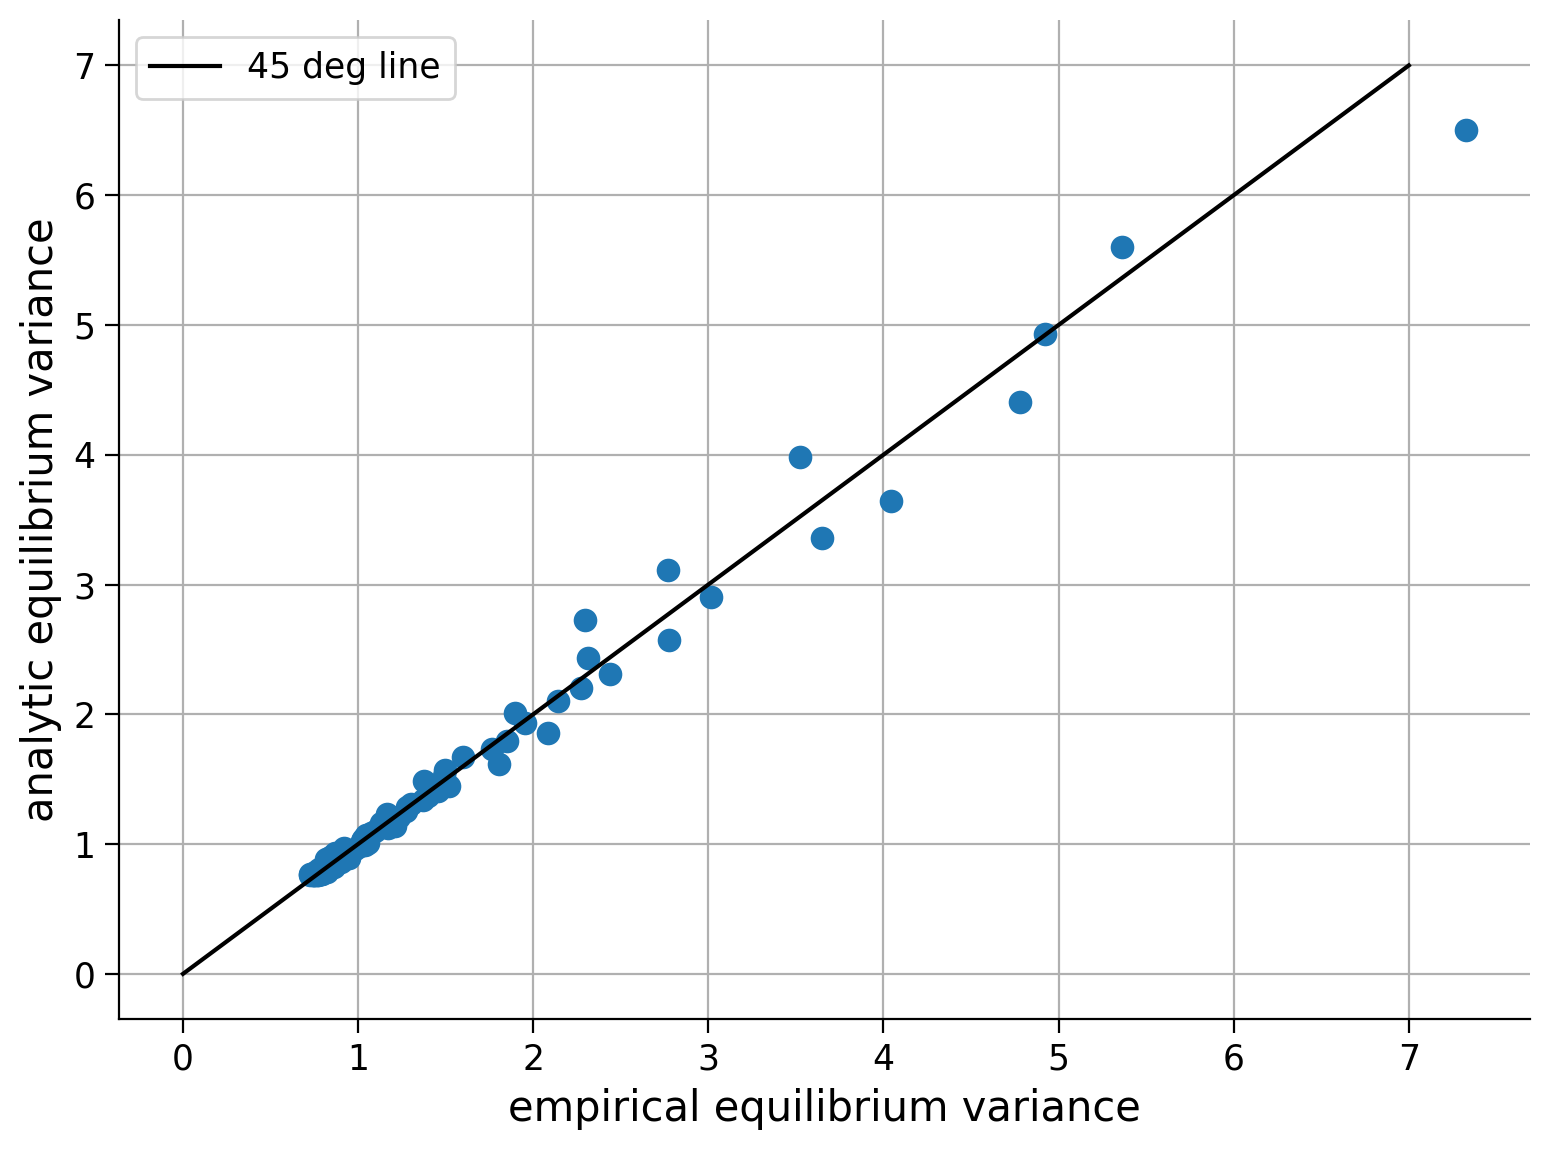

In [31]:
def ddm(T, x0, xinfty, lam, sig):
  t = np.arange(0, T, 1.)
  x = np.zeros_like(t)
  x[0] = x0

  for k in range(len(t)-1):
    x[k+1] = xinfty + lam * (x[k] - xinfty) + np.random.normal(0, sig)

  return t, x


# computes equilibrium variance of ddm
# returns variance
def ddm_eq_var(T, x0, xinfty, lam, sig):
  t, x = ddm(T, x0, xinfty, lam, sig)

  # returns variance of the second half of the simulation
  # this is a hack: assumes system has settled by second half
  return x[-round(T/2):].var()


np.random.seed(2020) # set random seed

# sweep through values for lambda
lambdas = np.arange(0.05, 0.95, 0.01)
empirical_variances = np.zeros_like(lambdas)
analytical_variances = np.zeros_like(lambdas)

sig = 0.87

# compute empirical equilibrium variance
for i, lam in enumerate(lambdas):
  empirical_variances[i] = ddm_eq_var(5000, x0, xinfty, lambdas[i], sig)



# Hint: you can also do this in one line outside the loop!
analytical_variances = sig**2 / (1 - lambdas**2)

# Plot the empirical variance vs analytical variance
var_comparison_plot(empirical_variances, analytical_variances)

# Autoregressive Models

#### Helper Functions

In [32]:
# @title Plotting Functions

def plot_residual_histogram(res):
  """Helper function for Exercise 4A"""
  plt.figure()
  plt.hist(res)
  plt.xlabel('error in linear model')
  plt.title(f'stdev of errors = {res.std():.4f}')
  plt.show()


def plot_training_fit(x1, x2, p):
  """Helper function for Exercise 4B"""
  plt.figure()
  plt.scatter(x2 + np.random.standard_normal(len(x2))*0.02,
              np.dot(x1.T, p), alpha=0.2)
  plt.title(f'Training fit, order {r} AR model')
  plt.xlabel('x')
  plt.ylabel('estimated x')
  plt.show()

In [33]:
def build_time_delay_matrices(x, r):
    """
    Builds x1 and x2 for regression

    Args:
    x (numpy array of floats): data to be auto regressed
    r (scalar): order of Autoregression model

    Returns:
    (numpy array of floats) : to predict "x2"
    (numpy array of floats) : predictors of size [r,n-r], "x1"

    """
    # construct the time-delayed data matrices for order-r AR model
    x1 = np.ones(len(x)-r)
    x1 = np.vstack((x1, x[0:-r]))
    xprime = x
    for i in range(r-1):
        xprime = np.roll(xprime, -1)
        x1 = np.vstack((x1, xprime[0:-r]))

    x2 = x[r:]

    return x1, x2


def AR_prediction(x_test, p):
    """
    Returns the prediction for test data "x_test" with the regression
    coefficients p

    Args:
    x_test (numpy array of floats): test data to be predicted
    p (numpy array of floats): regression coefficients of size [r] after
    solving the autoregression (order r) problem on train data

    Returns:
    (numpy array of floats): Predictions for test data. +1 if positive and -1
    if negative.
    """
    x1, x2 = build_time_delay_matrices(x_test, len(p)-1)

    # Evaluating the AR_model function fit returns a number.
    # We take the sign (- or +) of this number as the model's guess.
    return np.sign(np.dot(x1.T, p))

def error_rate(x_test, p):
    """
    Returns the error of the Autoregression model. Error is the number of
    mismatched predictions divided by total number of test points.

    Args:
    x_test (numpy array of floats): data to be predicted
    p (numpy array of floats): regression coefficients of size [r] after
    solving the autoregression (order r) problem on train data

    Returns:
    (float): Error (percentage).
    """
    x1, x2 = build_time_delay_matrices(x_test, len(p)-1)

    return np.count_nonzero(x2 - AR_prediction(x_test, p)) / len(x2)

#### OU Process

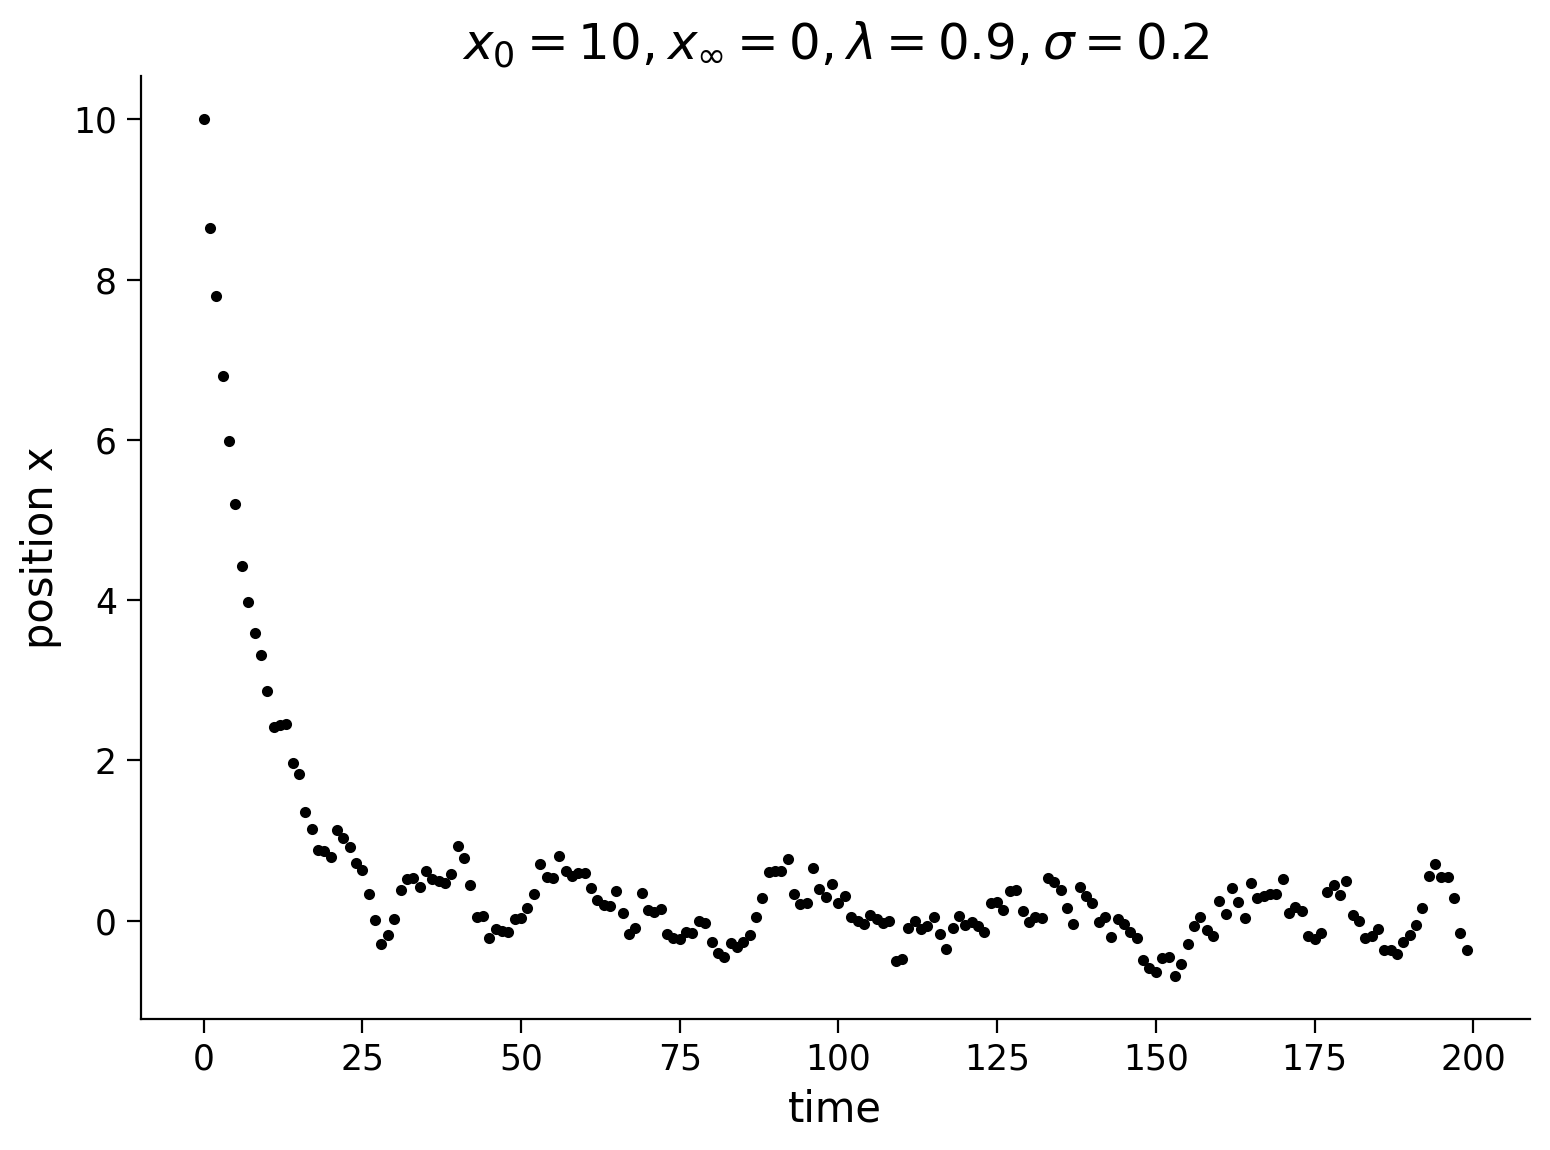

In [34]:
# @markdown Execute to simulate the drift diffusion model
np.random.seed(2020) # set random seed

# parameters
T = 200
x0 = 10
xinfty = 0
lam = 0.9
sig = 0.2

# drift-diffusion model from tutorial 3
t, x = ddm(T, x0, xinfty, lam, sig)

plt.figure()
plt.title('$x_0=%d, x_{\\infty}=%d, \\lambda=%0.1f, \\sigma=%0.1f$' % (x0, xinfty, lam, sig))
plt.plot(t, x, 'k.')
plt.xlabel('time')
plt.ylabel('position x')
plt.show()

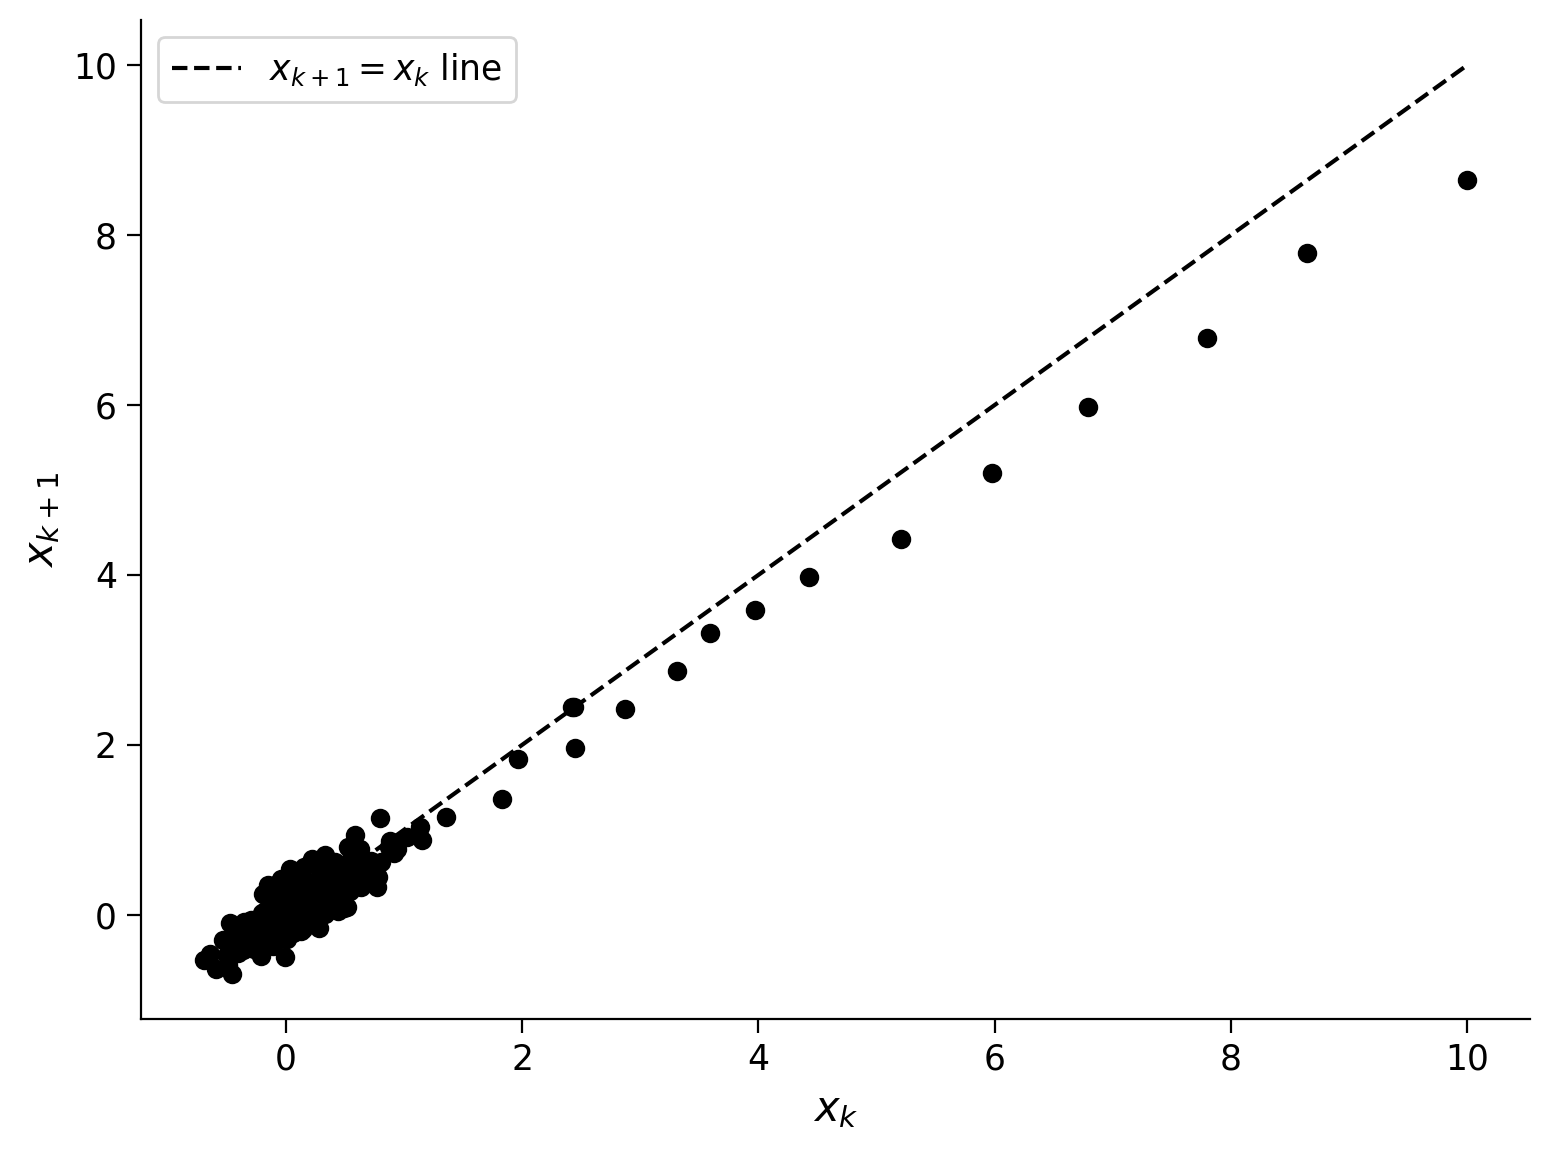

In [35]:
# @markdown Execute to visualize X(k) vs. X(k+1)
# make a scatter plot of every data point in x
# at time k versus time k+1
plt.figure()
plt.scatter(x[0:-2], x[1:-1], color='k')
plt.plot([0, 10], [0, 10], 'k--', label='$x_{k+1} = x_k$ line')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$')
plt.legend()
plt.show()

<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:33: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_36226/2128615712.py:33: SyntaxWarning: invalid escape sequence '\l'
  mytitle = 'True $\lambda$ = {lam:.4f}, Estimate $\lambda$ = {lam_hat:.4f}'


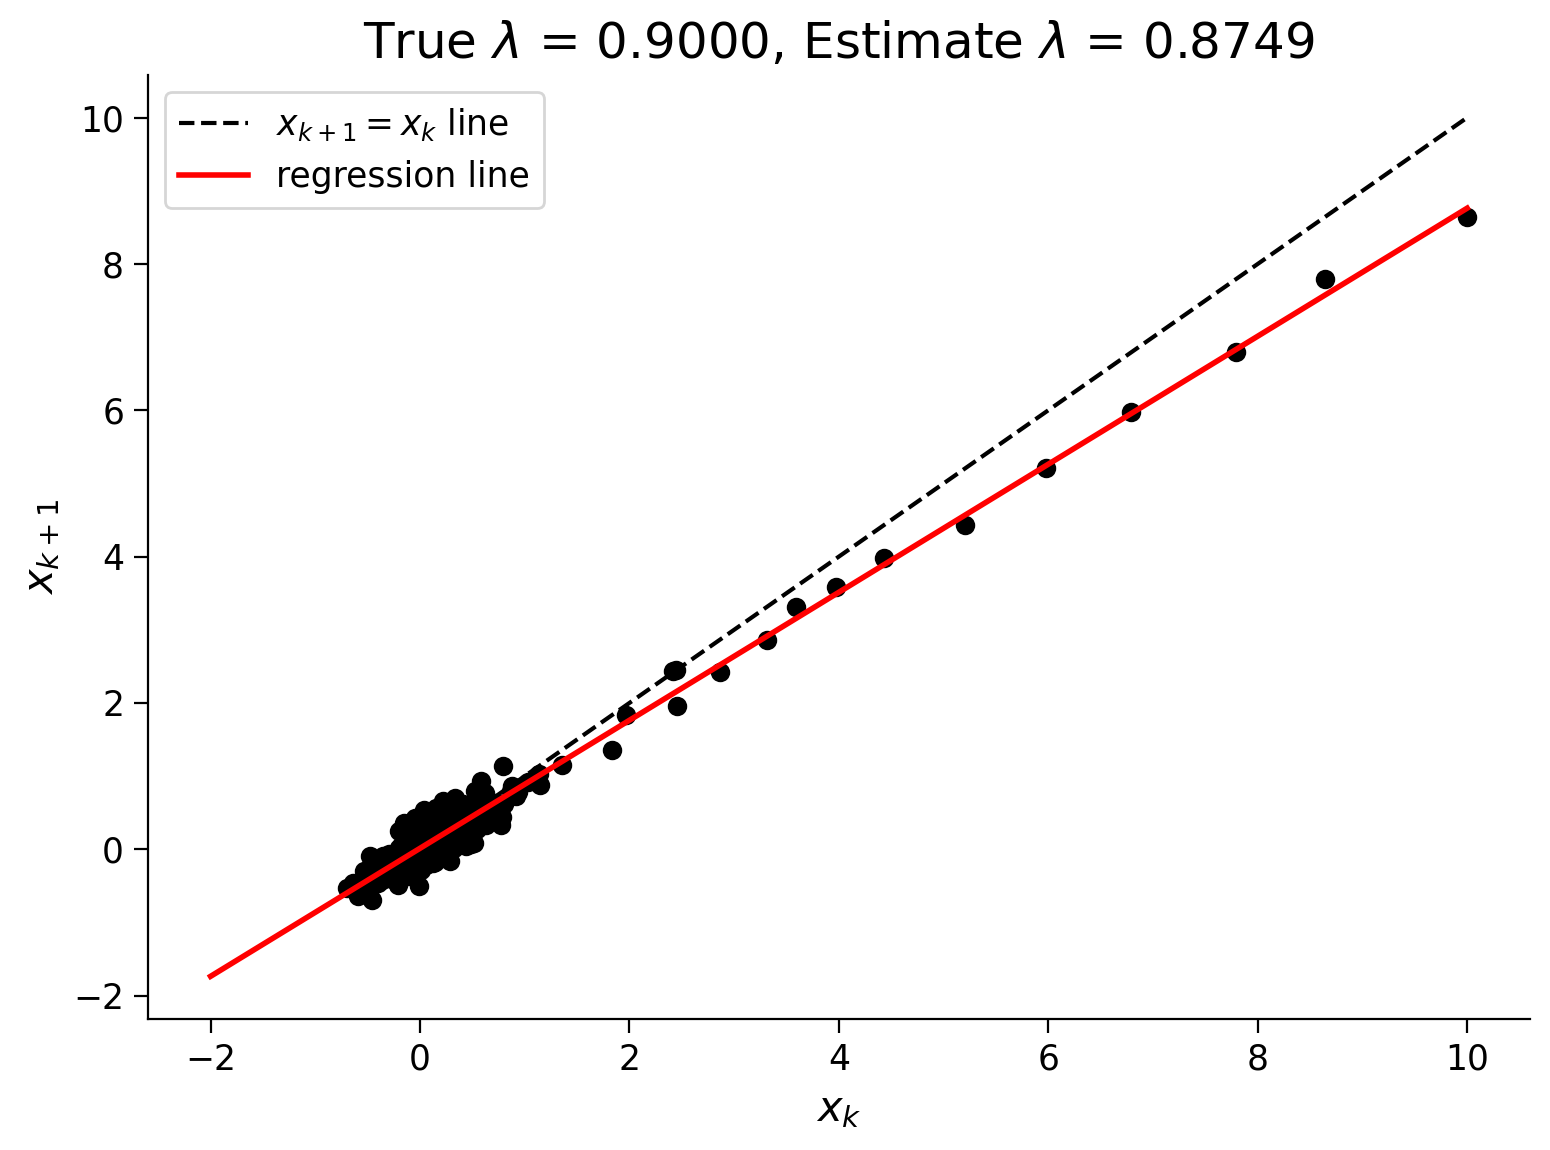

In [36]:
# @markdown Execute to solve for lambda through autoregression
# build the two data vectors from x
x1 = x[0:-2]
x1 = x1[:, np.newaxis]**[0, 1]

x2 = x[1:-1]

# solve for an estimate of lambda as a linear regression problem
p, res, rnk, s = np.linalg.lstsq(x1, x2, rcond=None)

# here we've artificially added a vector of 1's to the x1 array,
# so that our linear regression problem has an intercept term to fit.
# we expect this coefficient to be close to 0.
# the second coefficient in the regression is the linear term:
# that's the one we're after!
lam_hat = p[1]

# plot the data points
fig = plt.figure()
plt.scatter(x[0:-2], x[1:-1], color='k')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$')

# plot the 45 degree line
plt.plot([0, 10], [0, 10], 'k--', label='$x_{k+1} = x_k$ line')


# plot the regression line on top
xx = np.linspace(-sig*10, max(x), 100)
yy = p[0] + lam_hat * xx
plt.plot(xx, yy, 'r', linewidth=2, label='regression line')

mytitle = 'True $\lambda$ = {lam:.4f}, Estimate $\lambda$ = {lam_hat:.4f}'
plt.title(mytitle.format(lam=lam, lam_hat=lam_hat))
plt.legend()
plt.show()

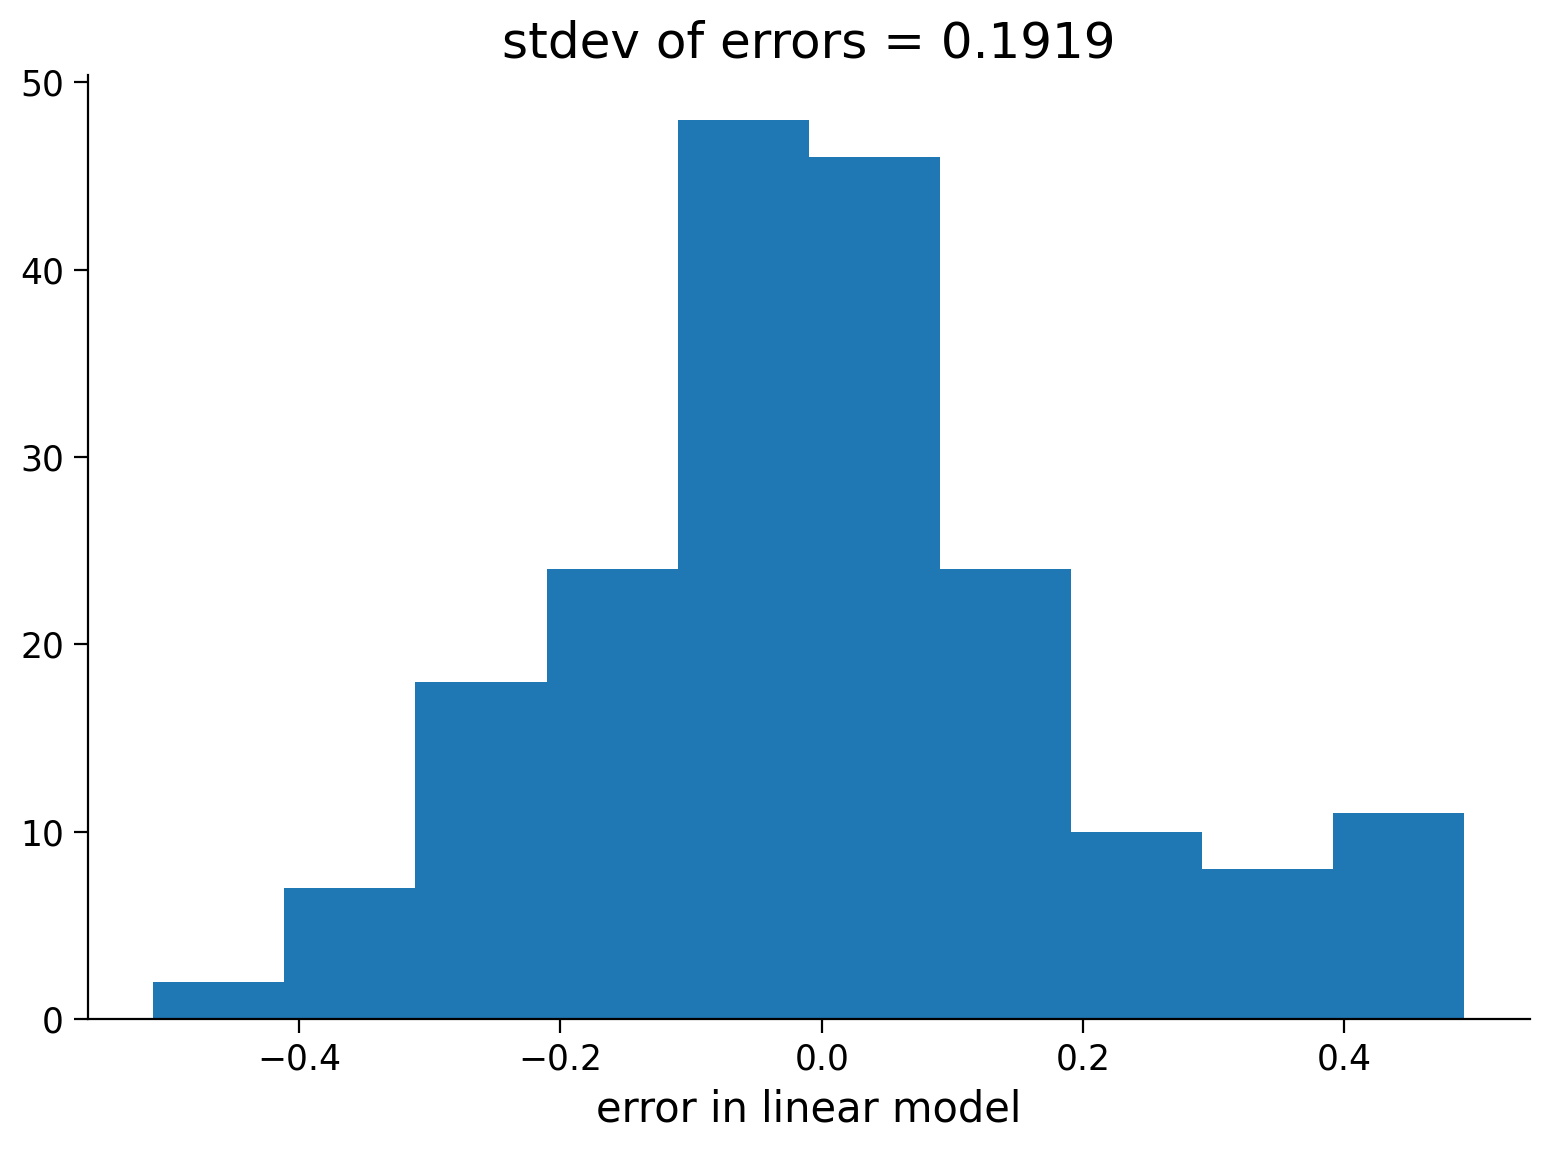

In [38]:
# compute the predicted values using the autoregressive model (lam_hat), and
# the residual is the difference between x2 and the prediction
res = x2 - np.dot(x1, p)

# Visualize
plot_residual_histogram(res)

#### Higher-Order Autoregression

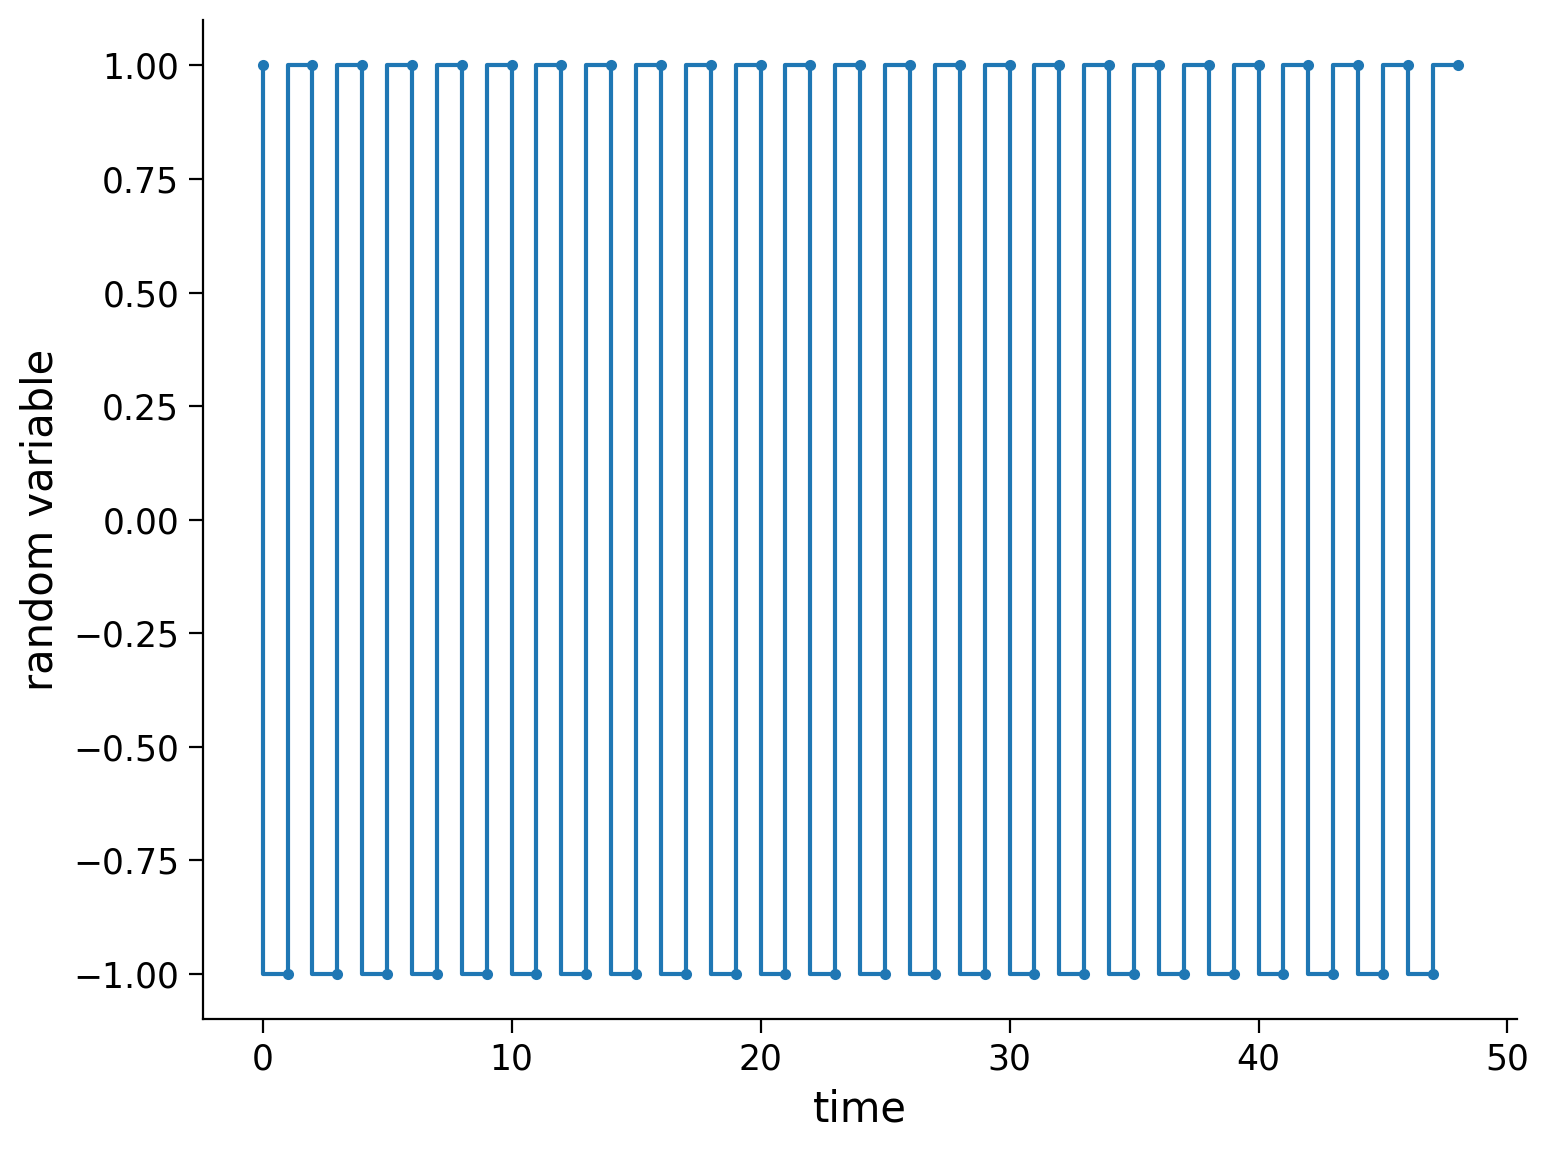

In [39]:
# this sequence is entirely predictable, so an AR model should work
monkey_at_typewriter = '1010101010101010101010101010101010101010101010101'

# Bonus: this sequence is also predictable, but does an order-1 AR model work?
#monkey_at_typewriter = '100100100100100100100100100100100100100'

# function to turn chars to numpy array,
# coding it this way makes the math easier
# '0' -> -1
# '1' -> +1
def char2array(s):
  m = [int(c) for c in s]
  x = np.array(m)
  return x*2 - 1


x = char2array(monkey_at_typewriter)

plt.figure()
plt.step(x, '.-')
plt.xlabel('time')
plt.ylabel('random variable')
plt.show()

In [40]:
# build the two data vectors from x
x1 = x[0:-2]
x1 = x1[:, np.newaxis]**[0, 1]

x2 = x[1:-1]

# solve for an estimate of lambda as a linear regression problem
p, res, rnk, s = np.linalg.lstsq(x1, x2, rcond=None)

# take a look at the resulting regression coefficients
print(f'alpha_0 = {p[0]:.2f}, alpha_1 = {p[1]:.2f}')

alpha_0 = -0.00, alpha_1 = -1.00


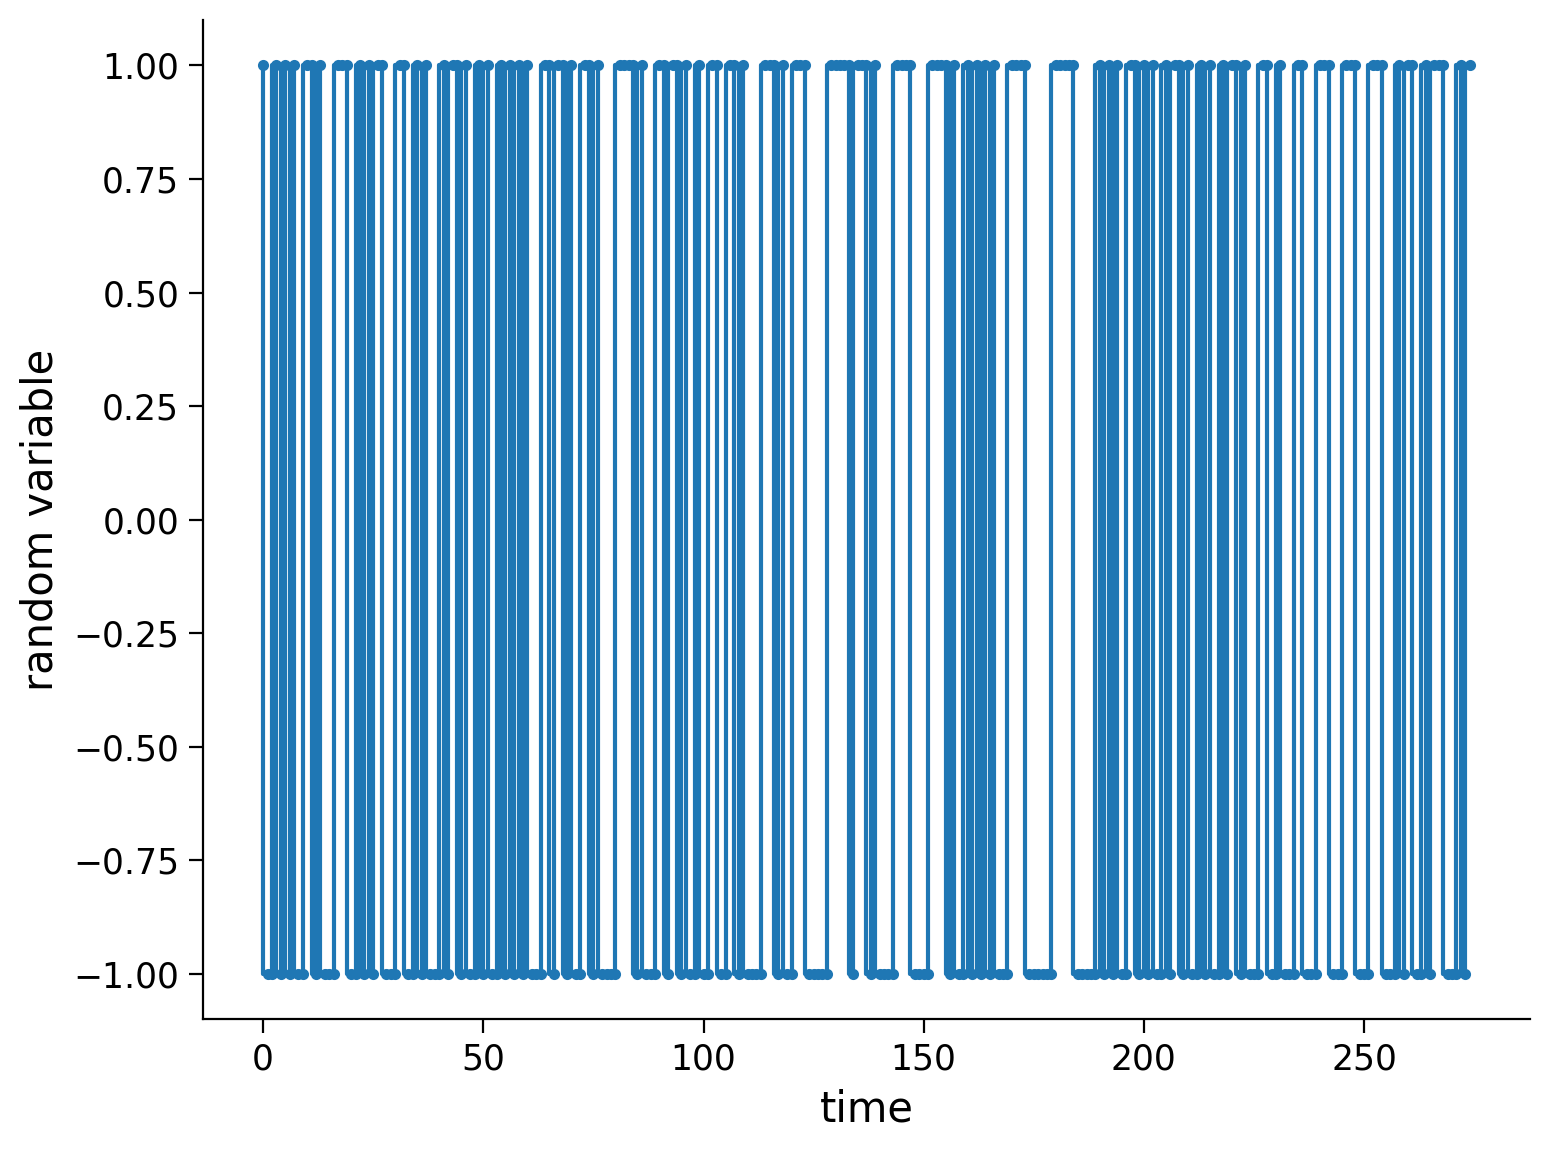

In [41]:
# data generated by 9-yr-old JAB:
# we will be using this sequence to train the data
monkey_at_typewriter = '10010101001101000111001010110001100101000101101001010010101010001101101001101000011110100011011010010011001101000011101001110000011111011101000011110000111101001010101000111100000011111000001010100110101001011010010100101101000110010001100011100011100011100010110010111000101'

# we will be using this sequence to test the data
test_monkey = '00100101100001101001100111100101011100101011101001010101000010110101001010100011110'

x = char2array(monkey_at_typewriter)
test = char2array(test_monkey)

## testing: machine generated randint should be entirely unpredictable
## uncomment the lines below to try random numbers instead
# np.random.seed(2020) # set random seed
# x = char2array(np.random.randint(2, size=500))
# test = char2array(np.random.randint(2, size=500))

plt.figure()
plt.step(x, '.-')
plt.xlabel('time')
plt.ylabel('random variable')
plt.show()

In [43]:
# @markdown Execute this cell to get helper function `AR_model`

def AR_model(x, r):
    """
    Solves Autoregression problem of order (r) for x

    Args:
    x (numpy array of floats): data to be auto regressed
    r (scalar): order of Autoregression model

    Returns:
    (numpy array of floats) : to predict "x2"
    (numpy array of floats) : predictors of size [r,n-r], "x1"
    (numpy array of floats): coefficients of length [r] for prediction after
    solving the regression problem "p"
    """
    x1, x2 = build_time_delay_matrices(x, r)

    # solve for an estimate of lambda as a linear regression problem
    p, res, rnk, s = np.linalg.lstsq(x1.T, x2, rcond=None)

    return x1, x2, p

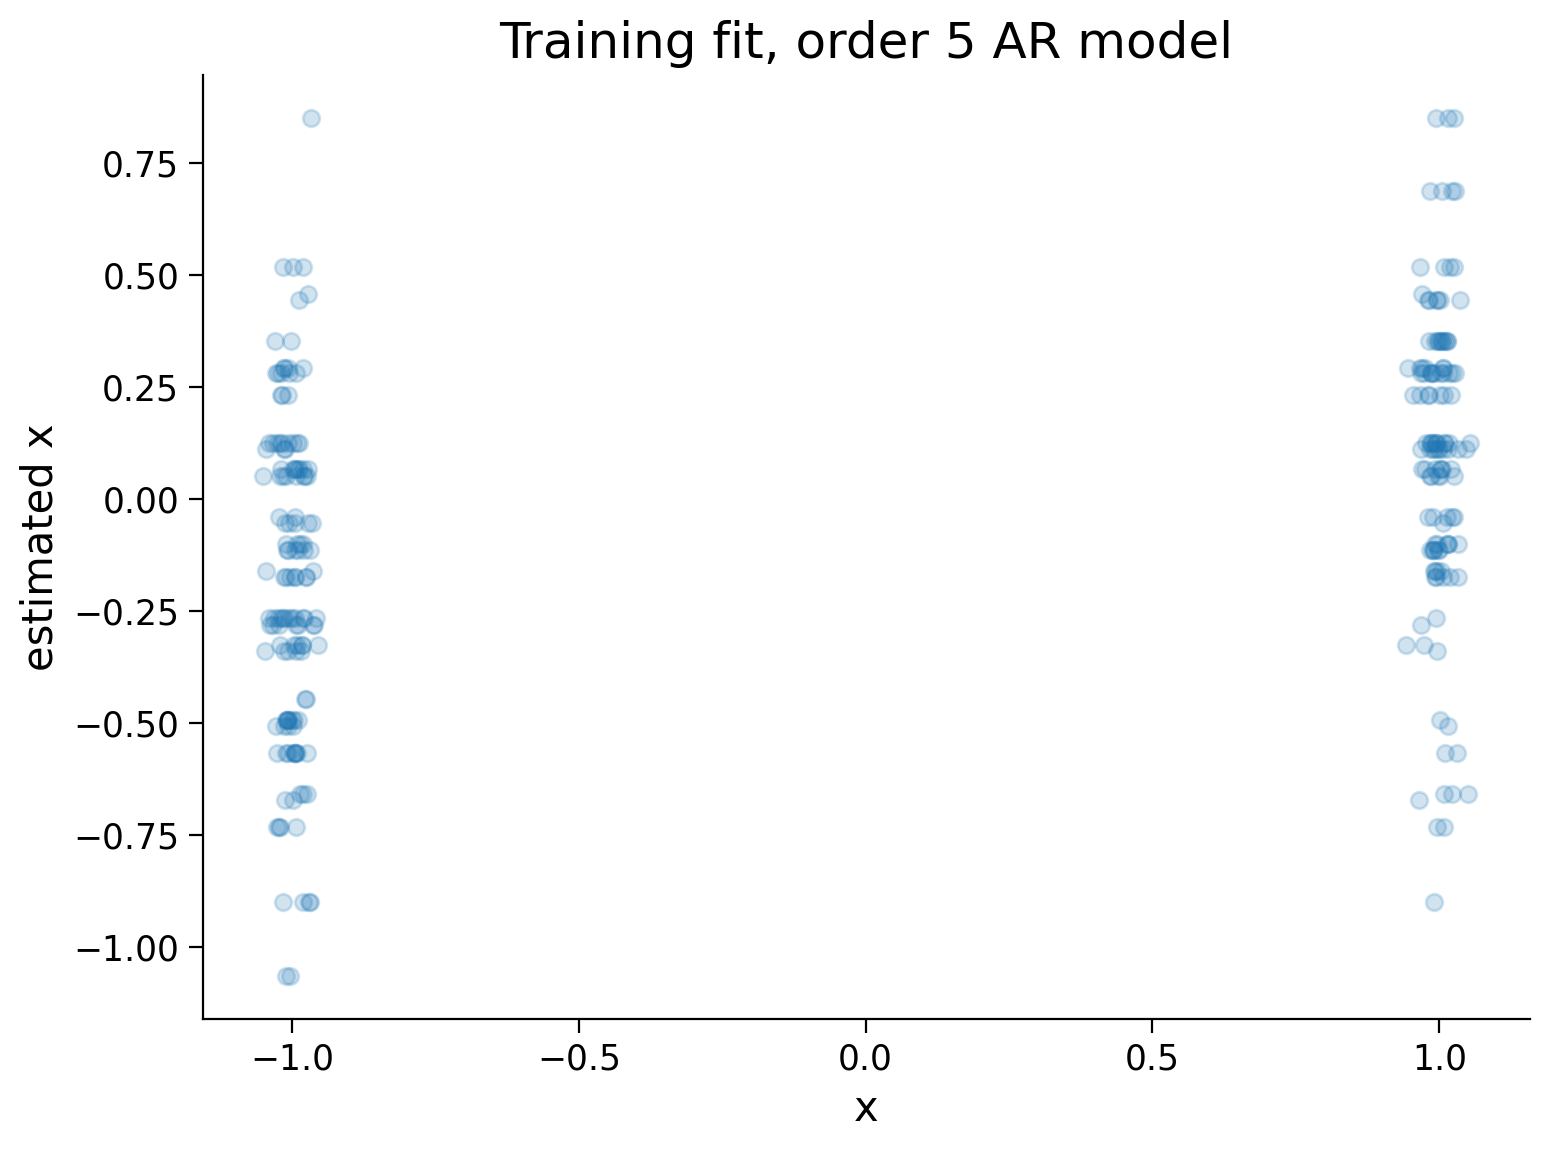

In [44]:

# define the model order, and use AR_model() to generate the model and prediction
r = 5
x1, x2, p = AR_model(x, r)

# Plot the Training data fit
# Note that this adds a small amount of jitter to horizontal axis for visualization purposes
plot_training_fit(x1, x2, p)

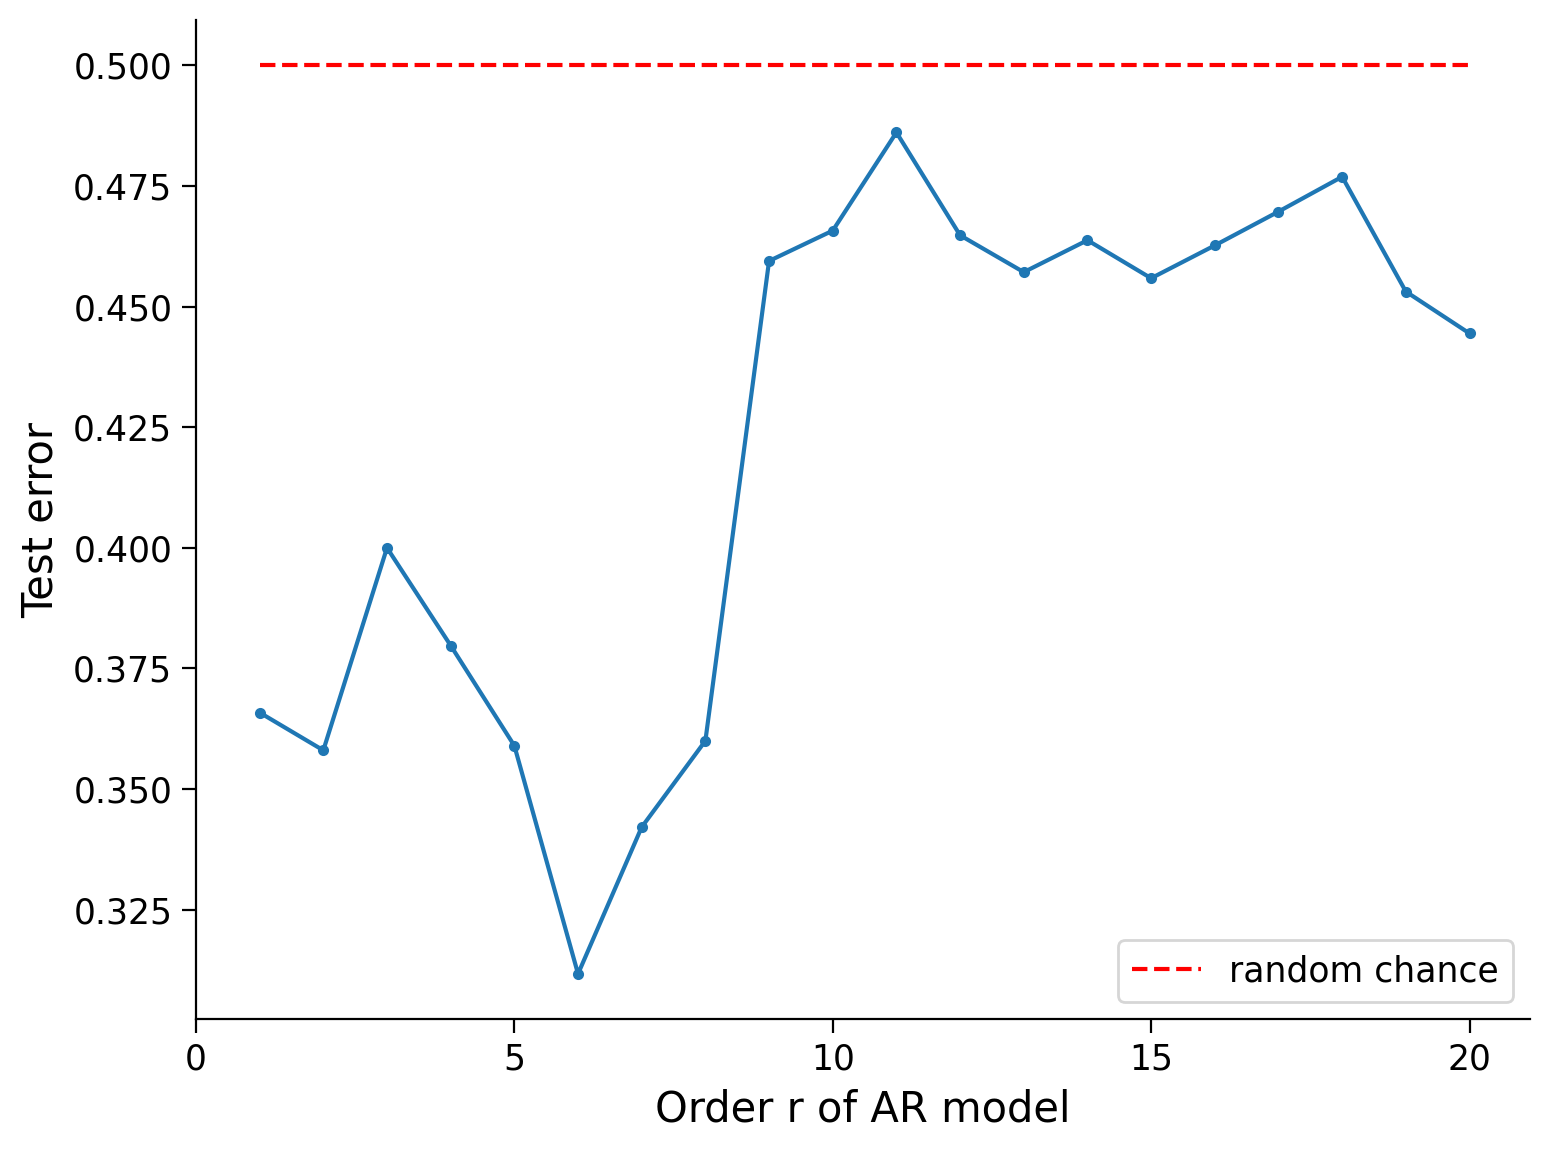

In [45]:
# @markdown Execute to visualize errors for different orders

# range of r's to try
r = np.arange(1, 21)
err = np.ones_like(r) * 1.0

for i, rr in enumerate(r):
  # fitting the model on training data
  x1, x2, p = AR_model(x, rr)
  # computing and storing the test error
  test_error = error_rate(test, p)
  err[i] = test_error


plt.figure()
plt.plot(r, err, '.-')
plt.plot([1, r[-1]], [0.5, 0.5], 'r--', label='random chance')
plt.xlabel('Order r of AR model')
plt.ylabel('Test error')
plt.xticks(np.arange(0,25,5))
plt.legend()
plt.show()